In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(16, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
        
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.target_model(next_states)
        max_next_Q_values = np.max(next_Q_values, axis= 1)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (6,))   #direction of motion_one_hot(4), curr_x, curr_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(16, activation = 'relu')(x)
        x = Dense(4)(x) #modulate by 1,2,3,4 
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.steps_per_epoch = 1
        self.gamma = 0.9
    
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
        
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_mod = self.exp_policy(state)
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        next_state = next_dir_one_hot[:]
        next_state = np.array(next_state)
        
        self.replay_buffer.append(state, action_mod-1, reward, next_state, done)
        
        
        return new_loc, reward, done
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.target_model(next_states)
        max_next_Q_values = np.max(next_Q_values, axis= 1)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.1 0.9]
 [0.6 0.4]
 [0.3 0.4]
 [0.5 0.4]
 [0.1 0.5]
 [0.7 0.2]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 756
Trainable params: 756
Non-trainable params: 0
_________________________________________________________________
None
Model: "functional_3"
___________________________________________________

  0%|▏                                                                             | 25/10000 [00:00<00:41, 242.05it/s]

Mean Reward = 13.0
1
Mean Reward = -1.9
1
Mean Reward = -2.0
1
Mean Reward = -2.6
0
Mean Reward = -3.8

  0%|▍                                                                             | 49/10000 [00:00<00:43, 227.12it/s]


0
Mean Reward = -3.4
0


  1%|▌                                                                              | 71/10000 [00:00<01:44, 94.59it/s]

Mean Reward = -1.6
0
Mean Reward = -3.9
2
Updated Weights

  1%|▋                                                                              | 89/10000 [00:00<02:02, 81.23it/s]


Mean Reward = -2.3
1
Mean Reward = -3.0

  1%|▊                                                                              | 97/10000 [00:00<02:04, 79.23it/s]


0
Updated Weights
Mean Reward = -1.6
1


  1%|▉                                                                             | 119/10000 [00:01<03:12, 51.39it/s]

Mean Reward = -6.4
0


  1%|▉                                                                             | 125/10000 [00:01<03:44, 43.98it/s]

Mean Reward = -5.0
0
Updated Weights


  1%|█                                                                             | 135/10000 [00:01<04:00, 41.09it/s]

Mean Reward = -5.3
1


  1%|█▏                                                                            | 145/10000 [00:02<04:23, 37.38it/s]

Mean Reward = -4.4
1


  2%|█▏                                                                            | 157/10000 [00:02<05:06, 32.13it/s]

Updated Weights
Mean Reward = -4.6
0


  2%|█▎                                                                            | 165/10000 [00:02<05:55, 27.66it/s]

Mean Reward = -7.2
0


  2%|█▎                                                                            | 174/10000 [00:03<06:44, 24.31it/s]

Mean Reward = 0.4
1
Updated Weights

  2%|█▍                                                                            | 181/10000 [00:03<06:11, 26.45it/s]


Mean Reward = 1.1
1


  2%|█▌                                                                            | 193/10000 [00:04<06:15, 26.10it/s]

Mean Reward = 1.0
1


  2%|█▌                                                                            | 205/10000 [00:04<06:33, 24.87it/s]

Updated Weights
Mean Reward = -0.7
1


  2%|█▋                                                                            | 214/10000 [00:05<08:14, 19.78it/s]

Mean Reward = -3.7
1


  2%|█▋                                                                            | 223/10000 [00:05<08:03, 20.23it/s]

Mean Reward = 1.4
2


  2%|█▊                                                                            | 229/10000 [00:05<07:29, 21.75it/s]

Updated Weights


  2%|█▊                                                                            | 235/10000 [00:06<07:47, 20.90it/s]

Mean Reward = -2.6
2


  2%|█▉                                                                            | 244/10000 [00:06<07:54, 20.57it/s]

Mean Reward = -2.4
1


  3%|█▉                                                                            | 253/10000 [00:06<07:52, 20.62it/s]

Updated Weights
Mean Reward = 1.2
2


  3%|██                                                                            | 264/10000 [00:07<09:07, 17.77it/s]

Mean Reward = -2.0
0


  3%|██                                                                            | 271/10000 [00:07<08:15, 19.63it/s]

Mean Reward = 3.3
2


  3%|██▏                                                                           | 279/10000 [00:08<08:38, 18.75it/s]

Updated Weights


  3%|██▏                                                                           | 283/10000 [00:08<08:41, 18.63it/s]

Mean Reward = 0.4
1


  3%|██▎                                                                           | 293/10000 [00:09<09:13, 17.54it/s]

Mean Reward = -5.0
0


  3%|██▎                                                                           | 303/10000 [00:09<10:27, 15.44it/s]

Updated Weights
Mean Reward = -3.0
0


  3%|██▍                                                                           | 313/10000 [00:10<10:23, 15.53it/s]

Mean Reward = -2.2
0


  3%|██▌                                                                           | 323/10000 [00:11<10:44, 15.02it/s]

Mean Reward = 0.2
0


  3%|██▌                                                                           | 328/10000 [00:11<08:40, 18.58it/s]

Updated Weights


  3%|██▌                                                                           | 333/10000 [00:11<09:16, 17.38it/s]

Mean Reward = 5.6
5


  3%|██▋                                                                           | 343/10000 [00:12<11:15, 14.29it/s]

Mean Reward = 0.8
0


  4%|██▊                                                                           | 353/10000 [00:13<11:03, 14.54it/s]

Updated Weights
Mean Reward = -5.0
0


  4%|██▊                                                                           | 362/10000 [00:13<11:00, 14.60it/s]

Mean Reward = -1.9
1


  4%|██▉                                                                           | 372/10000 [00:14<12:25, 12.91it/s]

Mean Reward = -4.1
1


  4%|██▉                                                                           | 378/10000 [00:14<12:41, 12.63it/s]

Updated Weights


  4%|██▉                                                                           | 382/10000 [00:15<13:01, 12.30it/s]

Mean Reward = -6.4
0


  4%|███                                                                           | 393/10000 [00:16<11:39, 13.73it/s]

Mean Reward = -5.6
1


  4%|███▏                                                                          | 401/10000 [00:16<13:00, 12.31it/s]

Updated Weights
Mean Reward = -10.6
0


  4%|███▏                                                                          | 413/10000 [00:17<13:50, 11.54it/s]

Mean Reward = -8.5
1


  4%|███▎                                                                          | 423/10000 [00:18<11:38, 13.70it/s]

Mean Reward = -9.4
0


  4%|███▎                                                                          | 427/10000 [00:18<12:31, 12.74it/s]

Updated Weights


  4%|███▎                                                                          | 432/10000 [00:19<11:35, 13.75it/s]

Mean Reward = 1.8
2


  4%|███▍                                                                          | 442/10000 [00:19<12:55, 12.32it/s]

Mean Reward = -2.6
0


  5%|███▌                                                                          | 452/10000 [00:20<12:42, 12.53it/s]

Updated Weights
Mean Reward = -1.0
0


  5%|███▌                                                                          | 462/10000 [00:21<12:12, 13.02it/s]

Mean Reward = -0.4
1


  5%|███▋                                                                          | 472/10000 [00:22<12:13, 13.00it/s]

Mean Reward = -2.0
0


  5%|███▋                                                                          | 478/10000 [00:22<12:18, 12.89it/s]

Updated Weights


  5%|███▊                                                                          | 482/10000 [00:23<13:31, 11.73it/s]

Mean Reward = -1.0
0


  5%|███▊                                                                          | 492/10000 [00:23<12:49, 12.35it/s]

Mean Reward = 2.0
0


  5%|███▉                                                                          | 500/10000 [00:24<13:16, 11.93it/s]

Updated Weights
Mean Reward = 0.0
0


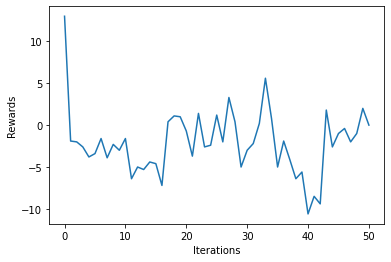

  5%|███▉                                                                          | 512/10000 [00:25<14:37, 10.81it/s]

Mean Reward = -1.2
0


  5%|████                                                                          | 522/10000 [00:26<13:24, 11.78it/s]

Mean Reward = -0.4
0


  5%|████                                                                          | 528/10000 [00:27<12:22, 12.76it/s]

Updated Weights


  5%|████▏                                                                         | 532/10000 [00:27<11:27, 13.76it/s]

Mean Reward = 0.8
2


  5%|████▏                                                                         | 542/10000 [00:28<11:47, 13.36it/s]

Mean Reward = 3.0
2


  6%|████▎                                                                         | 552/10000 [00:29<12:38, 12.45it/s]

Updated Weights
Mean Reward = 2.7
1


  6%|████▍                                                                         | 562/10000 [00:29<13:20, 11.79it/s]

Mean Reward = 1.4
0


  6%|████▍                                                                         | 572/10000 [00:30<14:06, 11.14it/s]

Mean Reward = 1.4
0


  6%|████▌                                                                         | 578/10000 [00:31<13:40, 11.48it/s]

Updated Weights


  6%|████▌                                                                         | 582/10000 [00:31<14:12, 11.05it/s]

Mean Reward = 0.2
0


  6%|████▌                                                                         | 592/10000 [00:32<14:56, 10.49it/s]

Mean Reward = 1.8
0


  6%|████▋                                                                         | 602/10000 [00:33<18:38,  8.40it/s]

Updated Weights
Mean Reward = 2.4
1


  6%|████▊                                                                         | 612/10000 [00:34<15:38, 10.00it/s]

Mean Reward = 1.2
1


  6%|████▊                                                                         | 623/10000 [00:35<15:39,  9.98it/s]

Mean Reward = 0.2
0


  6%|████▉                                                                         | 627/10000 [00:36<14:37, 10.68it/s]

Updated Weights


  6%|████▉                                                                         | 633/10000 [00:36<14:49, 10.54it/s]

Mean Reward = 1.8
1


  6%|█████                                                                         | 643/10000 [00:37<13:04, 11.93it/s]

Mean Reward = 0.4
1


  7%|█████                                                                         | 654/10000 [00:38<12:58, 12.00it/s]

Updated Weights
Mean Reward = -1.4
2


  7%|█████▏                                                                        | 662/10000 [00:39<14:28, 10.75it/s]

Mean Reward = -4.5
1


  7%|█████▎                                                                        | 674/10000 [00:40<12:07, 12.81it/s]

Mean Reward = -2.7
1


  7%|█████▎                                                                        | 678/10000 [00:40<11:39, 13.32it/s]

Updated Weights


  7%|█████▎                                                                        | 682/10000 [00:41<13:53, 11.17it/s]

Mean Reward = 5.3
4


  7%|█████▍                                                                        | 692/10000 [00:41<13:26, 11.55it/s]

Mean Reward = 3.9
2


  7%|█████▍                                                                        | 702/10000 [00:42<13:23, 11.57it/s]

Updated Weights
Mean Reward = 4.3
2


  7%|█████▌                                                                        | 712/10000 [00:43<18:17,  8.46it/s]

Mean Reward = 2.2
1


  7%|█████▋                                                                        | 722/10000 [00:45<18:20,  8.43it/s]

Mean Reward = -3.2
0


  7%|█████▋                                                                        | 727/10000 [00:45<18:52,  8.19it/s]

Updated Weights


  7%|█████▋                                                                        | 731/10000 [00:46<16:57,  9.11it/s]

Mean Reward = 0.0
0


  7%|█████▊                                                                        | 742/10000 [00:47<15:12, 10.15it/s]

Mean Reward = 3.6
1


  8%|█████▊                                                                        | 752/10000 [00:48<14:14, 10.82it/s]

Updated Weights
Mean Reward = 3.3
1


  8%|█████▉                                                                        | 762/10000 [00:49<15:04, 10.22it/s]

Mean Reward = 2.0
0


  8%|██████                                                                        | 772/10000 [00:50<15:14, 10.09it/s]

Mean Reward = 2.3
1


  8%|██████                                                                        | 776/10000 [00:50<13:45, 11.17it/s]

Updated Weights


  8%|██████                                                                        | 782/10000 [00:51<15:00, 10.23it/s]

Mean Reward = 2.2
1


  8%|██████▏                                                                       | 792/10000 [00:52<15:13, 10.08it/s]

Mean Reward = 0.8
0


  8%|██████▎                                                                       | 802/10000 [00:53<17:15,  8.88it/s]

Updated Weights
Mean Reward = 1.0
0


  8%|██████▎                                                                       | 812/10000 [00:54<16:31,  9.27it/s]

Mean Reward = -0.2
0


  8%|██████▍                                                                       | 821/10000 [00:55<15:39,  9.77it/s]

Mean Reward = -0.4
0


  8%|██████▍                                                                       | 827/10000 [00:55<18:08,  8.42it/s]

Updated Weights


  8%|██████▍                                                                       | 832/10000 [00:56<19:07,  7.99it/s]

Mean Reward = 2.4
0


  8%|██████▌                                                                       | 842/10000 [00:57<16:45,  9.11it/s]

Mean Reward = 0.6
0


  9%|██████▋                                                                       | 852/10000 [00:58<16:29,  9.24it/s]

Updated Weights
Mean Reward = 1.2
0


  9%|██████▋                                                                       | 862/10000 [00:59<15:39,  9.73it/s]

Mean Reward = 2.4
0


  9%|██████▊                                                                       | 872/10000 [01:00<16:58,  8.97it/s]

Mean Reward = 2.6
0


  9%|██████▊                                                                       | 877/10000 [01:01<15:53,  9.56it/s]

Updated Weights


  9%|██████▉                                                                       | 882/10000 [01:01<16:43,  9.09it/s]

Mean Reward = -1.4
0


  9%|██████▉                                                                       | 892/10000 [01:02<16:13,  9.36it/s]

Mean Reward = 2.0
1


  9%|███████                                                                       | 902/10000 [01:04<20:42,  7.32it/s]

Updated Weights
Mean Reward = -1.0
0


  9%|███████                                                                       | 912/10000 [01:05<20:29,  7.39it/s]

Mean Reward = 1.8
0


  9%|███████▏                                                                      | 922/10000 [01:06<18:05,  8.37it/s]

Mean Reward = 2.4
1


  9%|███████▏                                                                      | 927/10000 [01:07<19:57,  7.57it/s]

Updated Weights


  9%|███████▎                                                                      | 932/10000 [01:07<16:45,  9.02it/s]

Mean Reward = 3.0
1


  9%|███████▎                                                                      | 942/10000 [01:09<19:49,  7.61it/s]

Mean Reward = 2.6
1


 10%|███████▍                                                                      | 952/10000 [01:10<19:10,  7.86it/s]

Updated Weights
Mean Reward = 1.9
1


 10%|███████▌                                                                      | 962/10000 [01:11<19:48,  7.61it/s]

Mean Reward = 2.3
1


 10%|███████▌                                                                      | 972/10000 [01:12<17:59,  8.36it/s]

Mean Reward = 2.8
1


 10%|███████▌                                                                      | 977/10000 [01:13<20:09,  7.46it/s]

Updated Weights


 10%|███████▋                                                                      | 982/10000 [01:14<17:39,  8.51it/s]

Mean Reward = 3.7
1


 10%|███████▋                                                                      | 992/10000 [01:15<17:11,  8.74it/s]

Mean Reward = 0.6
0


 10%|███████▋                                                                     | 1000/10000 [01:16<17:02,  8.80it/s]

Updated Weights
Mean Reward = 1.9
1


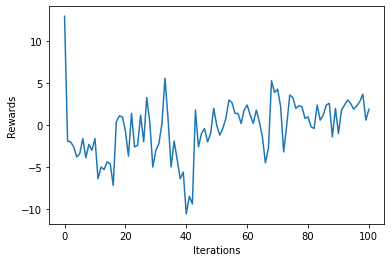

 10%|███████▊                                                                     | 1012/10000 [01:17<17:49,  8.40it/s]

Mean Reward = 1.4
0


 10%|███████▊                                                                     | 1022/10000 [01:18<17:28,  8.56it/s]

Mean Reward = 1.4
0


 10%|███████▉                                                                     | 1027/10000 [01:19<17:23,  8.60it/s]

Updated Weights


 10%|███████▉                                                                     | 1032/10000 [01:20<17:29,  8.55it/s]

Mean Reward = 1.2
0


 10%|████████                                                                     | 1042/10000 [01:21<16:57,  8.80it/s]

Mean Reward = 3.2
0


 11%|████████                                                                     | 1052/10000 [01:22<18:07,  8.23it/s]

Updated Weights
Mean Reward = 1.2
0


 11%|████████▏                                                                    | 1062/10000 [01:23<17:26,  8.54it/s]

Mean Reward = 2.8
1


 11%|████████▎                                                                    | 1072/10000 [01:24<17:29,  8.50it/s]

Mean Reward = 2.0
0


 11%|████████▎                                                                    | 1077/10000 [01:25<17:20,  8.57it/s]

Updated Weights


 11%|████████▎                                                                    | 1082/10000 [01:25<17:43,  8.39it/s]

Mean Reward = 2.2
0


 11%|████████▍                                                                    | 1092/10000 [01:27<17:44,  8.37it/s]

Mean Reward = 2.0
0


 11%|████████▍                                                                    | 1102/10000 [01:28<17:08,  8.65it/s]

Updated Weights
Mean Reward = 2.4
0


 11%|████████▌                                                                    | 1112/10000 [01:29<17:45,  8.34it/s]

Mean Reward = 1.0
0


 11%|████████▋                                                                    | 1122/10000 [01:30<16:25,  9.00it/s]

Mean Reward = 3.2
1


 11%|████████▋                                                                    | 1127/10000 [01:31<17:39,  8.38it/s]

Updated Weights


 11%|████████▋                                                                    | 1132/10000 [01:31<17:41,  8.35it/s]

Mean Reward = 2.0
0


 11%|████████▊                                                                    | 1142/10000 [01:32<15:28,  9.54it/s]

Mean Reward = 1.9
2


 12%|████████▊                                                                    | 1152/10000 [01:33<18:20,  8.04it/s]

Updated Weights
Mean Reward = 0.8
0


 12%|████████▉                                                                    | 1162/10000 [01:35<19:20,  7.62it/s]

Mean Reward = 3.0
0


 12%|█████████                                                                    | 1172/10000 [01:36<18:21,  8.02it/s]

Mean Reward = 3.2
0


 12%|█████████                                                                    | 1177/10000 [01:37<19:10,  7.67it/s]

Updated Weights


 12%|█████████                                                                    | 1181/10000 [01:37<18:13,  8.07it/s]

Mean Reward = 0.6
0


 12%|█████████▏                                                                   | 1192/10000 [01:38<18:30,  7.93it/s]

Mean Reward = 5.1
2


 12%|█████████▎                                                                   | 1202/10000 [01:40<18:09,  8.07it/s]

Updated Weights
Mean Reward = 1.8
0


 12%|█████████▎                                                                   | 1212/10000 [01:41<17:16,  8.48it/s]

Mean Reward = 3.8
0


 12%|█████████▍                                                                   | 1222/10000 [01:42<18:56,  7.73it/s]

Mean Reward = 3.0
0


 12%|█████████▍                                                                   | 1227/10000 [01:43<17:25,  8.39it/s]

Updated Weights


 12%|█████████▍                                                                   | 1232/10000 [01:43<16:55,  8.63it/s]

Mean Reward = 2.4
0


 12%|█████████▌                                                                   | 1242/10000 [01:44<17:24,  8.38it/s]

Mean Reward = 4.2
0


 13%|█████████▋                                                                   | 1252/10000 [01:46<18:55,  7.70it/s]

Updated Weights
Mean Reward = 2.4
0


 13%|█████████▋                                                                   | 1262/10000 [01:47<17:15,  8.43it/s]

Mean Reward = 2.2
0


 13%|█████████▊                                                                   | 1272/10000 [01:48<17:54,  8.12it/s]

Mean Reward = 2.0
0


 13%|█████████▊                                                                   | 1277/10000 [01:49<18:44,  7.75it/s]

Updated Weights


 13%|█████████▊                                                                   | 1282/10000 [01:49<17:06,  8.49it/s]

Mean Reward = 3.8
1


 13%|█████████▉                                                                   | 1291/10000 [01:50<18:58,  7.65it/s]

Mean Reward = 1.0
0


 13%|██████████                                                                   | 1302/10000 [01:52<22:03,  6.57it/s]

Updated Weights
Mean Reward = 3.5
1


 13%|██████████                                                                   | 1312/10000 [01:53<20:23,  7.10it/s]

Mean Reward = 2.2
0


 13%|██████████▏                                                                  | 1322/10000 [01:55<17:58,  8.04it/s]

Mean Reward = 3.8
1


 13%|██████████▏                                                                  | 1328/10000 [01:55<15:28,  9.34it/s]

Updated Weights


 13%|██████████▎                                                                  | 1332/10000 [01:56<16:53,  8.56it/s]

Mean Reward = 4.1
1


 13%|██████████▎                                                                  | 1342/10000 [01:57<19:22,  7.45it/s]

Mean Reward = 1.2
0


 14%|██████████▍                                                                  | 1352/10000 [01:58<17:26,  8.27it/s]

Updated Weights
Mean Reward = 4.4
1


 14%|██████████▍                                                                  | 1362/10000 [02:00<19:19,  7.45it/s]

Mean Reward = 4.5
1


 14%|██████████▌                                                                  | 1372/10000 [02:01<18:34,  7.74it/s]

Mean Reward = 4.4
1


 14%|██████████▌                                                                  | 1377/10000 [02:02<18:19,  7.84it/s]

Updated Weights


 14%|██████████▋                                                                  | 1382/10000 [02:02<18:42,  7.68it/s]

Mean Reward = 2.2
0


 14%|██████████▋                                                                  | 1393/10000 [02:03<15:28,  9.27it/s]

Mean Reward = 3.0
0


 14%|██████████▊                                                                  | 1401/10000 [02:04<17:47,  8.06it/s]

Updated Weights
Mean Reward = 6.3
1


 14%|██████████▊                                                                  | 1412/10000 [02:06<21:18,  6.72it/s]

Mean Reward = 4.0
0


 14%|██████████▉                                                                  | 1422/10000 [02:07<17:13,  8.30it/s]

Mean Reward = 4.0
0


 14%|██████████▉                                                                  | 1427/10000 [02:08<23:13,  6.15it/s]

Updated Weights


 14%|███████████                                                                  | 1432/10000 [02:09<23:13,  6.15it/s]

Mean Reward = 3.6
0


 14%|███████████                                                                  | 1443/10000 [02:10<15:45,  9.05it/s]

Mean Reward = 1.6
0


 15%|███████████▏                                                                 | 1452/10000 [02:11<18:06,  7.87it/s]

Updated Weights
Mean Reward = 5.7
2


 15%|███████████▎                                                                 | 1462/10000 [02:12<15:57,  8.91it/s]

Mean Reward = 2.6
1


 15%|███████████▎                                                                 | 1472/10000 [02:14<18:43,  7.59it/s]

Mean Reward = 2.2
0


 15%|███████████▎                                                                 | 1477/10000 [02:14<17:08,  8.29it/s]

Updated Weights


 15%|███████████▍                                                                 | 1482/10000 [02:15<17:22,  8.17it/s]

Mean Reward = 4.5
1


 15%|███████████▍                                                                 | 1492/10000 [02:16<17:59,  7.88it/s]

Mean Reward = 5.1
2


 15%|███████████▌                                                                 | 1500/10000 [02:17<17:44,  7.98it/s]

Updated Weights
Mean Reward = 2.6
0


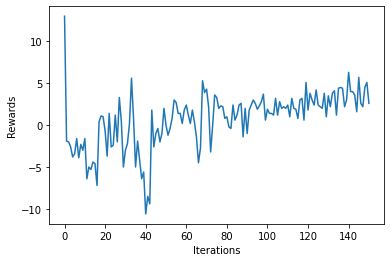

 15%|███████████▋                                                                 | 1513/10000 [02:19<16:17,  8.68it/s]

Mean Reward = 3.6
0


 15%|███████████▋                                                                 | 1522/10000 [02:20<17:43,  7.97it/s]

Mean Reward = 5.0
3


 15%|███████████▊                                                                 | 1527/10000 [02:21<17:06,  8.26it/s]

Updated Weights


 15%|███████████▊                                                                 | 1532/10000 [02:21<17:10,  8.22it/s]

Mean Reward = 3.2
0


 15%|███████████▊                                                                 | 1542/10000 [02:22<17:23,  8.11it/s]

Mean Reward = 5.2
2


 16%|███████████▉                                                                 | 1552/10000 [02:24<18:14,  7.72it/s]

Updated Weights
Mean Reward = 3.0
0


 16%|████████████                                                                 | 1562/10000 [02:25<17:33,  8.01it/s]

Mean Reward = 5.0
0


 16%|████████████                                                                 | 1572/10000 [02:26<17:08,  8.19it/s]

Mean Reward = 4.5
1


 16%|████████████▏                                                                | 1577/10000 [02:27<17:44,  7.91it/s]

Updated Weights


 16%|████████████▏                                                                | 1582/10000 [02:27<17:16,  8.12it/s]

Mean Reward = 2.2
0


 16%|████████████▎                                                                | 1592/10000 [02:28<16:46,  8.35it/s]

Mean Reward = 4.9
1


 16%|████████████▎                                                                | 1602/10000 [02:29<14:38,  9.56it/s]

Updated Weights
Mean Reward = 7.4
4


 16%|████████████▍                                                                | 1612/10000 [02:31<20:10,  6.93it/s]

Mean Reward = 3.0
0


 16%|████████████▍                                                                | 1620/10000 [02:32<23:11,  6.02it/s]

Mean Reward = 6.2
2


 16%|████████████▌                                                                | 1627/10000 [02:33<17:49,  7.83it/s]

Updated Weights


 16%|████████████▌                                                                | 1632/10000 [02:33<17:04,  8.17it/s]

Mean Reward = 5.2
2


 16%|████████████▋                                                                | 1642/10000 [02:34<17:05,  8.15it/s]

Mean Reward = 3.9
1


 17%|████████████▋                                                                | 1652/10000 [02:36<17:50,  7.80it/s]

Updated Weights
Mean Reward = 2.0
0


 17%|████████████▊                                                                | 1662/10000 [02:37<17:13,  8.07it/s]

Mean Reward = 0.6
0


 17%|████████████▉                                                                | 1673/10000 [02:38<15:03,  9.22it/s]

Mean Reward = 2.4
0


 17%|████████████▉                                                                | 1676/10000 [02:39<14:55,  9.30it/s]

Updated Weights


 17%|████████████▉                                                                | 1682/10000 [02:39<21:35,  6.42it/s]

Mean Reward = 3.8
2


 17%|█████████████                                                                | 1693/10000 [02:40<13:45, 10.07it/s]

Mean Reward = 2.9
2


 17%|█████████████                                                                | 1703/10000 [02:42<14:05,  9.81it/s]

Updated Weights
Mean Reward = 5.1
2


 17%|█████████████▏                                                               | 1712/10000 [02:43<15:38,  8.83it/s]

Mean Reward = 4.2
2


 17%|█████████████▎                                                               | 1721/10000 [02:43<13:23, 10.30it/s]

Mean Reward = 5.9
1


 17%|█████████████▎                                                               | 1727/10000 [02:44<14:15,  9.67it/s]

Updated Weights


 17%|█████████████▎                                                               | 1732/10000 [02:45<15:45,  8.74it/s]

Mean Reward = 1.4
0


 17%|█████████████▍                                                               | 1742/10000 [02:46<12:05, 11.38it/s]

Mean Reward = 1.4
2


 18%|█████████████▍                                                               | 1752/10000 [02:46<12:53, 10.66it/s]

Updated Weights
Mean Reward = 3.6
0


 18%|█████████████▌                                                               | 1762/10000 [02:47<12:50, 10.69it/s]

Mean Reward = 2.4
0


 18%|█████████████▋                                                               | 1772/10000 [02:48<12:58, 10.56it/s]

Mean Reward = 3.0
0


 18%|█████████████▋                                                               | 1778/10000 [02:49<12:54, 10.61it/s]

Updated Weights


 18%|█████████████▋                                                               | 1782/10000 [02:49<12:56, 10.58it/s]

Mean Reward = 2.6
0


 18%|█████████████▊                                                               | 1792/10000 [02:50<13:06, 10.44it/s]

Mean Reward = 3.4
0


 18%|█████████████▉                                                               | 1802/10000 [02:51<11:55, 11.46it/s]

Updated Weights
Mean Reward = 4.0
1


 18%|█████████████▉                                                               | 1812/10000 [02:52<13:20, 10.23it/s]

Mean Reward = 3.2
0


 18%|██████████████                                                               | 1822/10000 [02:53<12:58, 10.51it/s]

Mean Reward = 3.0
1


 18%|██████████████                                                               | 1828/10000 [02:54<12:30, 10.90it/s]

Updated Weights


 18%|██████████████                                                               | 1832/10000 [02:54<12:26, 10.93it/s]

Mean Reward = -4.6
0


 18%|██████████████▏                                                              | 1842/10000 [02:55<10:33, 12.87it/s]

Mean Reward = -2.9
2


 19%|██████████████▎                                                              | 1853/10000 [02:56<12:00, 11.31it/s]

Updated Weights
Mean Reward = 3.2
1


 19%|██████████████▎                                                              | 1863/10000 [02:57<12:50, 10.56it/s]

Mean Reward = 4.5
1


 19%|██████████████▍                                                              | 1873/10000 [02:58<12:12, 11.09it/s]

Mean Reward = 3.4
0


 19%|██████████████▍                                                              | 1877/10000 [02:58<12:25, 10.89it/s]

Updated Weights


 19%|██████████████▍                                                              | 1883/10000 [02:59<13:01, 10.39it/s]

Mean Reward = 2.0
0


 19%|██████████████▌                                                              | 1893/10000 [02:59<11:34, 11.68it/s]

Mean Reward = 4.6
1


 19%|██████████████▋                                                              | 1903/10000 [03:00<12:26, 10.85it/s]

Updated Weights
Mean Reward = 4.0
1


 19%|██████████████▋                                                              | 1911/10000 [03:01<12:10, 11.08it/s]

Mean Reward = 3.0
0


 19%|██████████████▊                                                              | 1923/10000 [03:02<11:49, 11.38it/s]

Mean Reward = 3.5
1


 19%|██████████████▊                                                              | 1927/10000 [03:02<11:12, 12.00it/s]

Updated Weights


 19%|██████████████▉                                                              | 1933/10000 [03:03<12:02, 11.17it/s]

Mean Reward = 3.0
1


 19%|██████████████▉                                                              | 1941/10000 [03:04<12:38, 10.62it/s]

Mean Reward = 2.6
0


 20%|███████████████                                                              | 1953/10000 [03:05<12:40, 10.59it/s]

Updated Weights
Mean Reward = 3.6
0


 20%|███████████████                                                              | 1961/10000 [03:06<13:18, 10.07it/s]

Mean Reward = 2.0
0


 20%|███████████████▏                                                             | 1971/10000 [03:07<11:35, 11.54it/s]

Mean Reward = 4.7
1


 20%|███████████████▏                                                             | 1977/10000 [03:07<12:53, 10.37it/s]

Updated Weights


 20%|███████████████▎                                                             | 1981/10000 [03:08<14:03,  9.51it/s]

Mean Reward = 3.6
0


 20%|███████████████▎                                                             | 1992/10000 [03:09<11:35, 11.52it/s]

Mean Reward = 3.2
1


 20%|███████████████▍                                                             | 2000/10000 [03:09<11:48, 11.29it/s]

Updated Weights
Mean Reward = 3.2
0


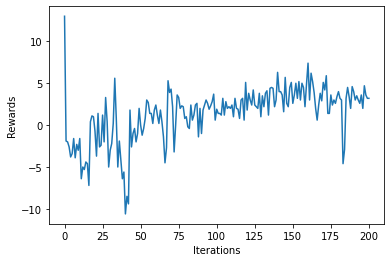

 20%|███████████████▍                                                             | 2012/10000 [03:11<13:23,  9.94it/s]

Mean Reward = 4.2
0


 20%|███████████████▌                                                             | 2022/10000 [03:12<12:40, 10.49it/s]

Mean Reward = 4.2
0


 20%|███████████████▌                                                             | 2026/10000 [03:12<12:50, 10.34it/s]

Updated Weights


 20%|███████████████▋                                                             | 2032/10000 [03:13<12:48, 10.36it/s]

Mean Reward = 3.4
0


 20%|███████████████▋                                                             | 2042/10000 [03:14<12:35, 10.54it/s]

Mean Reward = 3.2
0


 21%|███████████████▊                                                             | 2052/10000 [03:15<12:20, 10.73it/s]

Updated Weights
Mean Reward = 4.8
0


 21%|███████████████▉                                                             | 2062/10000 [03:15<12:16, 10.77it/s]

Mean Reward = 3.0
0


 21%|███████████████▉                                                             | 2072/10000 [03:16<12:09, 10.87it/s]

Mean Reward = 2.8
0


 21%|███████████████▉                                                             | 2076/10000 [03:17<12:22, 10.67it/s]

Updated Weights


 21%|████████████████                                                             | 2082/10000 [03:17<13:14,  9.97it/s]

Mean Reward = 4.4
0


 21%|████████████████                                                             | 2092/10000 [03:18<11:32, 11.42it/s]

Mean Reward = 5.0
2


 21%|████████████████▏                                                            | 2102/10000 [03:19<12:40, 10.38it/s]

Updated Weights
Mean Reward = 4.9
1


 21%|████████████████▎                                                            | 2112/10000 [03:20<12:04, 10.88it/s]

Mean Reward = 3.4
1


 21%|████████████████▎                                                            | 2122/10000 [03:21<12:24, 10.59it/s]

Mean Reward = 2.8
0


 21%|████████████████▍                                                            | 2128/10000 [03:21<10:02, 13.07it/s]

Updated Weights


 21%|████████████████▍                                                            | 2132/10000 [03:22<11:29, 11.42it/s]

Mean Reward = 5.5
2


 21%|████████████████▍                                                            | 2141/10000 [03:23<10:50, 12.09it/s]

Mean Reward = 4.0
1


 22%|████████████████▌                                                            | 2153/10000 [03:24<11:59, 10.90it/s]

Updated Weights
Mean Reward = 2.2
0


 22%|████████████████▋                                                            | 2163/10000 [03:24<11:32, 11.32it/s]

Mean Reward = 3.9
1


 22%|████████████████▋                                                            | 2171/10000 [03:25<11:51, 11.00it/s]

Mean Reward = 4.4
0


 22%|████████████████▊                                                            | 2177/10000 [03:26<12:10, 10.72it/s]

Updated Weights


 22%|████████████████▊                                                            | 2183/10000 [03:26<11:56, 10.91it/s]

Mean Reward = 3.0
0


 22%|████████████████▉                                                            | 2193/10000 [03:27<11:51, 10.97it/s]

Mean Reward = 4.2
0


 22%|████████████████▉                                                            | 2203/10000 [03:28<10:50, 11.98it/s]

Updated Weights
Mean Reward = 4.1
1


 22%|█████████████████                                                            | 2211/10000 [03:29<11:08, 11.64it/s]

Mean Reward = 4.0
1


 22%|█████████████████                                                            | 2221/10000 [03:30<11:55, 10.87it/s]

Mean Reward = 2.4
0


 22%|█████████████████▏                                                           | 2227/10000 [03:30<11:53, 10.90it/s]

Updated Weights


 22%|█████████████████▏                                                           | 2233/10000 [03:31<12:07, 10.68it/s]

Mean Reward = 2.8
0


 22%|█████████████████▎                                                           | 2241/10000 [03:31<10:23, 12.44it/s]

Mean Reward = 3.6
1


 23%|█████████████████▎                                                           | 2251/10000 [03:32<10:20, 12.50it/s]

Updated Weights
Mean Reward = 4.1
1


 23%|█████████████████▍                                                           | 2263/10000 [03:33<11:30, 11.21it/s]

Mean Reward = 3.6
0


 23%|█████████████████▌                                                           | 2273/10000 [03:34<10:31, 12.24it/s]

Mean Reward = 5.2
1


 23%|█████████████████▌                                                           | 2277/10000 [03:35<11:20, 11.34it/s]

Updated Weights


 23%|█████████████████▌                                                           | 2283/10000 [03:35<11:49, 10.87it/s]

Mean Reward = 2.8
0


 23%|█████████████████▋                                                           | 2291/10000 [03:36<11:57, 10.74it/s]

Mean Reward = 3.2
0


 23%|█████████████████▋                                                           | 2302/10000 [03:37<11:08, 11.52it/s]

Updated Weights
Mean Reward = 4.3
1


 23%|█████████████████▊                                                           | 2312/10000 [03:38<09:39, 13.26it/s]

Mean Reward = 4.3
2


 23%|█████████████████▉                                                           | 2322/10000 [03:38<10:40, 11.98it/s]

Mean Reward = 4.9
1


 23%|█████████████████▉                                                           | 2326/10000 [03:39<11:27, 11.16it/s]

Updated Weights


 23%|█████████████████▉                                                           | 2332/10000 [03:39<11:36, 11.01it/s]

Mean Reward = 3.4
0


 23%|██████████████████                                                           | 2342/10000 [03:40<11:39, 10.95it/s]

Mean Reward = 5.6
0


 24%|██████████████████                                                           | 2352/10000 [03:41<11:09, 11.42it/s]

Updated Weights
Mean Reward = 4.7
1


 24%|██████████████████▏                                                          | 2362/10000 [03:42<11:32, 11.03it/s]

Mean Reward = 3.4
0


 24%|██████████████████▎                                                          | 2372/10000 [03:43<11:54, 10.68it/s]

Mean Reward = 2.0
0


 24%|██████████████████▎                                                          | 2378/10000 [03:43<11:38, 10.92it/s]

Updated Weights


 24%|██████████████████▎                                                          | 2382/10000 [03:44<11:42, 10.85it/s]

Mean Reward = 2.2
0


 24%|██████████████████▍                                                          | 2393/10000 [03:45<10:41, 11.87it/s]

Mean Reward = 2.2
0


 24%|██████████████████▌                                                          | 2403/10000 [03:46<11:29, 11.01it/s]

Updated Weights
Mean Reward = 4.5
1


 24%|██████████████████▌                                                          | 2413/10000 [03:47<11:30, 10.99it/s]

Mean Reward = 4.0
0


 24%|██████████████████▋                                                          | 2423/10000 [03:48<11:41, 10.80it/s]

Mean Reward = 2.4
0


 24%|██████████████████▋                                                          | 2427/10000 [03:48<10:14, 12.33it/s]

Updated Weights


 24%|██████████████████▋                                                          | 2431/10000 [03:48<11:02, 11.43it/s]

Mean Reward = 4.5
1


 24%|██████████████████▊                                                          | 2443/10000 [03:49<11:24, 11.03it/s]

Mean Reward = 3.2
0


 25%|██████████████████▉                                                          | 2453/10000 [03:50<10:09, 12.39it/s]

Updated Weights
Mean Reward = 3.6
0


 25%|██████████████████▉                                                          | 2462/10000 [03:51<10:19, 12.17it/s]

Mean Reward = 6.1
2


 25%|███████████████████                                                          | 2472/10000 [03:52<11:06, 11.30it/s]

Mean Reward = 4.4
0


 25%|███████████████████                                                          | 2478/10000 [03:52<11:15, 11.13it/s]

Updated Weights


 25%|███████████████████                                                          | 2482/10000 [03:53<11:33, 10.85it/s]

Mean Reward = 2.8
0


 25%|███████████████████▏                                                         | 2492/10000 [03:54<10:49, 11.57it/s]

Mean Reward = 3.9
1


 25%|███████████████████▏                                                         | 2499/10000 [03:54<10:05, 12.38it/s]

Updated Weights
Mean Reward = 6.0
2


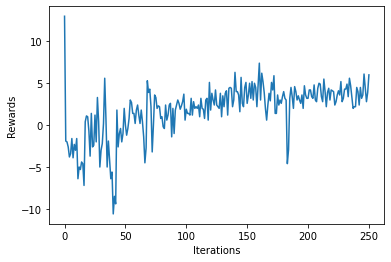

 25%|███████████████████▎                                                         | 2511/10000 [03:55<10:16, 12.14it/s]

Mean Reward = 5.1
1


 25%|███████████████████▍                                                         | 2524/10000 [03:56<09:30, 13.09it/s]

Mean Reward = 4.6
1


 25%|███████████████████▍                                                         | 2526/10000 [03:57<10:24, 11.97it/s]

Updated Weights


 25%|███████████████████▍                                                         | 2532/10000 [03:57<11:03, 11.26it/s]

Mean Reward = 4.3
1


 25%|███████████████████▌                                                         | 2542/10000 [03:58<11:30, 10.79it/s]

Mean Reward = 4.0
0


 26%|███████████████████▋                                                         | 2552/10000 [03:59<10:46, 11.52it/s]

Updated Weights
Mean Reward = 5.0
1


 26%|███████████████████▋                                                         | 2562/10000 [04:00<11:11, 11.08it/s]

Mean Reward = 2.8
0


 26%|███████████████████▊                                                         | 2573/10000 [04:01<10:40, 11.60it/s]

Mean Reward = 3.2
1


 26%|███████████████████▊                                                         | 2577/10000 [04:01<11:01, 11.21it/s]

Updated Weights


 26%|███████████████████▊                                                         | 2581/10000 [04:01<11:38, 10.63it/s]

Mean Reward = 3.0
0


 26%|███████████████████▉                                                         | 2591/10000 [04:02<11:47, 10.47it/s]

Mean Reward = 2.6
0


 26%|████████████████████                                                         | 2602/10000 [04:04<14:28,  8.52it/s]

Updated Weights
Mean Reward = 4.8
0


 26%|████████████████████                                                         | 2612/10000 [04:05<16:26,  7.49it/s]

Mean Reward = 3.4
0


 26%|████████████████████▏                                                        | 2622/10000 [04:06<16:59,  7.24it/s]

Mean Reward = 4.4
0


 26%|████████████████████▏                                                        | 2627/10000 [04:07<16:55,  7.26it/s]

Updated Weights


 26%|████████████████████▎                                                        | 2632/10000 [04:08<15:46,  7.79it/s]

Mean Reward = 4.7
1


 26%|████████████████████▎                                                        | 2642/10000 [04:09<15:32,  7.89it/s]

Mean Reward = 4.0
1


 27%|████████████████████▍                                                        | 2652/10000 [04:10<18:21,  6.67it/s]

Updated Weights
Mean Reward = 3.8
1


 27%|████████████████████▍                                                        | 2662/10000 [04:12<16:12,  7.54it/s]

Mean Reward = 3.4
0


 27%|████████████████████▌                                                        | 2672/10000 [04:13<16:25,  7.43it/s]

Mean Reward = 3.2
0


 27%|████████████████████▌                                                        | 2677/10000 [04:14<15:45,  7.75it/s]

Updated Weights


 27%|████████████████████▋                                                        | 2682/10000 [04:14<16:11,  7.53it/s]

Mean Reward = -1.0
0


 27%|████████████████████▋                                                        | 2692/10000 [04:16<14:11,  8.59it/s]

Mean Reward = 3.5
2


 27%|████████████████████▊                                                        | 2702/10000 [04:17<15:08,  8.04it/s]

Updated Weights
Mean Reward = 3.8
0


 27%|████████████████████▉                                                        | 2712/10000 [04:18<15:05,  8.05it/s]

Mean Reward = 5.8
0


 27%|████████████████████▉                                                        | 2722/10000 [04:19<15:25,  7.87it/s]

Mean Reward = 3.4
0


 27%|████████████████████▉                                                        | 2727/10000 [04:20<15:07,  8.02it/s]

Updated Weights


 27%|█████████████████████                                                        | 2732/10000 [04:21<14:42,  8.24it/s]

Mean Reward = 5.6
1


 27%|█████████████████████                                                        | 2742/10000 [04:22<14:58,  8.08it/s]

Mean Reward = 4.2
0


 28%|█████████████████████▏                                                       | 2752/10000 [04:23<13:15,  9.11it/s]

Updated Weights
Mean Reward = 4.2
1


 28%|█████████████████████▎                                                       | 2762/10000 [04:24<15:15,  7.90it/s]

Mean Reward = 2.8
0


 28%|█████████████████████▎                                                       | 2772/10000 [04:25<14:43,  8.18it/s]

Mean Reward = 2.9
1


 28%|█████████████████████▍                                                       | 2777/10000 [04:26<14:30,  8.30it/s]

Updated Weights


 28%|█████████████████████▍                                                       | 2782/10000 [04:27<15:17,  7.87it/s]

Mean Reward = 3.4
0


 28%|█████████████████████▍                                                       | 2792/10000 [04:28<13:55,  8.62it/s]

Mean Reward = 4.0
1


 28%|█████████████████████▌                                                       | 2801/10000 [04:29<15:29,  7.74it/s]

Updated Weights
Mean Reward = 5.1
1


 28%|█████████████████████▋                                                       | 2812/10000 [04:31<15:29,  7.73it/s]

Mean Reward = 2.4
0


 28%|█████████████████████▋                                                       | 2822/10000 [04:32<14:52,  8.04it/s]

Mean Reward = 3.4
1


 28%|█████████████████████▊                                                       | 2827/10000 [04:32<14:55,  8.01it/s]

Updated Weights


 28%|█████████████████████▊                                                       | 2832/10000 [04:33<17:02,  7.01it/s]

Mean Reward = 3.7
1


 28%|█████████████████████▉                                                       | 2842/10000 [04:34<15:49,  7.54it/s]

Mean Reward = 2.8
0


 29%|█████████████████████▉                                                       | 2852/10000 [04:36<15:35,  7.64it/s]

Updated Weights
Mean Reward = 2.0
0


 29%|██████████████████████                                                       | 2862/10000 [04:37<15:02,  7.91it/s]

Mean Reward = 3.8
0


 29%|██████████████████████                                                       | 2872/10000 [04:38<15:09,  7.84it/s]

Mean Reward = 1.8
0


 29%|██████████████████████▏                                                      | 2877/10000 [04:39<14:56,  7.94it/s]

Updated Weights


 29%|██████████████████████▏                                                      | 2883/10000 [04:40<13:12,  8.98it/s]

Mean Reward = 3.0
0


 29%|██████████████████████▎                                                      | 2892/10000 [04:41<14:33,  8.14it/s]

Mean Reward = 5.8
1


 29%|██████████████████████▎                                                      | 2901/10000 [04:42<15:19,  7.72it/s]

Updated Weights
Mean Reward = 4.8
0


 29%|██████████████████████▍                                                      | 2912/10000 [04:44<18:09,  6.50it/s]

Mean Reward = 4.4
0


 29%|██████████████████████▍                                                      | 2922/10000 [04:45<17:51,  6.61it/s]

Mean Reward = 5.4
1


 29%|██████████████████████▌                                                      | 2927/10000 [04:46<16:57,  6.95it/s]

Updated Weights


 29%|██████████████████████▌                                                      | 2932/10000 [04:46<16:10,  7.28it/s]

Mean Reward = 5.3
2


 29%|██████████████████████▋                                                      | 2942/10000 [04:48<15:15,  7.71it/s]

Mean Reward = 3.2
0


 30%|██████████████████████▋                                                      | 2952/10000 [04:49<16:22,  7.17it/s]

Updated Weights
Mean Reward = 0.8
0


 30%|██████████████████████▊                                                      | 2962/10000 [04:50<15:13,  7.70it/s]

Mean Reward = 4.0
0


 30%|██████████████████████▉                                                      | 2972/10000 [04:51<13:20,  8.78it/s]

Mean Reward = 2.9
1


 30%|██████████████████████▉                                                      | 2977/10000 [04:52<14:43,  7.95it/s]

Updated Weights


 30%|██████████████████████▉                                                      | 2982/10000 [04:53<16:03,  7.29it/s]

Mean Reward = -3.0
0


 30%|███████████████████████                                                      | 2992/10000 [04:54<13:51,  8.42it/s]

Mean Reward = 4.9
1


 30%|███████████████████████                                                      | 3000/10000 [04:55<14:55,  7.81it/s]

Updated Weights
Mean Reward = 3.0
0


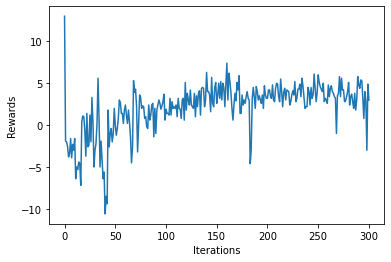

 30%|███████████████████████▏                                                     | 3012/10000 [04:57<17:50,  6.53it/s]

Mean Reward = 3.6
0


 30%|███████████████████████▎                                                     | 3022/10000 [04:58<16:38,  6.99it/s]

Mean Reward = 1.6
0


 30%|███████████████████████▎                                                     | 3027/10000 [04:59<16:52,  6.89it/s]

Updated Weights


 30%|███████████████████████▎                                                     | 3032/10000 [05:00<15:44,  7.38it/s]

Mean Reward = 2.4
0


 30%|███████████████████████▍                                                     | 3042/10000 [05:01<15:23,  7.54it/s]

Mean Reward = 3.8
0


 31%|███████████████████████▌                                                     | 3052/10000 [05:02<14:58,  7.73it/s]

Updated Weights
Mean Reward = 3.6
0


 31%|███████████████████████▌                                                     | 3062/10000 [05:04<14:49,  7.80it/s]

Mean Reward = 3.6
1


 31%|███████████████████████▋                                                     | 3073/10000 [05:05<15:47,  7.31it/s]

Mean Reward = 3.0
0


 31%|███████████████████████▋                                                     | 3077/10000 [05:06<17:48,  6.48it/s]

Updated Weights


 31%|███████████████████████▋                                                     | 3082/10000 [05:06<15:40,  7.36it/s]

Mean Reward = 3.4
1


 31%|███████████████████████▊                                                     | 3092/10000 [05:08<12:04,  9.54it/s]

Mean Reward = 5.0
2


 31%|███████████████████████▉                                                     | 3102/10000 [05:09<15:17,  7.52it/s]

Updated Weights
Mean Reward = 5.7
2


 31%|███████████████████████▉                                                     | 3112/10000 [05:10<12:08,  9.45it/s]

Mean Reward = 4.8
2


 31%|████████████████████████                                                     | 3122/10000 [05:11<14:01,  8.18it/s]

Mean Reward = 2.6
0


 31%|████████████████████████                                                     | 3127/10000 [05:12<14:52,  7.70it/s]

Updated Weights


 31%|████████████████████████                                                     | 3132/10000 [05:12<15:49,  7.24it/s]

Mean Reward = 3.4
0


 31%|████████████████████████▏                                                    | 3142/10000 [05:14<14:44,  7.76it/s]

Mean Reward = 4.0
0


 32%|████████████████████████▎                                                    | 3152/10000 [05:15<15:40,  7.28it/s]

Updated Weights
Mean Reward = 2.8
0


 32%|████████████████████████▎                                                    | 3162/10000 [05:17<15:20,  7.42it/s]

Mean Reward = 3.4
0


 32%|████████████████████████▍                                                    | 3172/10000 [05:18<15:42,  7.24it/s]

Mean Reward = 5.4
1


 32%|████████████████████████▍                                                    | 3176/10000 [05:19<15:52,  7.16it/s]

Updated Weights


 32%|████████████████████████▌                                                    | 3182/10000 [05:20<17:45,  6.40it/s]

Mean Reward = 3.6
0


 32%|████████████████████████▌                                                    | 3192/10000 [05:21<15:28,  7.33it/s]

Mean Reward = 2.4
0


 32%|████████████████████████▋                                                    | 3202/10000 [05:22<15:30,  7.30it/s]

Updated Weights
Mean Reward = 3.9
1


 32%|████████████████████████▋                                                    | 3212/10000 [05:24<15:32,  7.28it/s]

Mean Reward = 3.4
0


 32%|████████████████████████▊                                                    | 3222/10000 [05:25<15:12,  7.43it/s]

Mean Reward = 2.0
0


 32%|████████████████████████▊                                                    | 3227/10000 [05:26<15:15,  7.39it/s]

Updated Weights


 32%|████████████████████████▉                                                    | 3232/10000 [05:26<17:07,  6.58it/s]

Mean Reward = 2.4
0


 32%|████████████████████████▉                                                    | 3242/10000 [05:28<16:49,  6.69it/s]

Mean Reward = 5.8
0


 33%|█████████████████████████                                                    | 3252/10000 [05:29<14:38,  7.68it/s]

Updated Weights
Mean Reward = 4.8
1


 33%|█████████████████████████                                                    | 3262/10000 [05:30<13:36,  8.25it/s]

Mean Reward = 2.8
1


 33%|█████████████████████████▏                                                   | 3273/10000 [05:32<11:51,  9.45it/s]

Mean Reward = 3.5
1


 33%|█████████████████████████▏                                                   | 3277/10000 [05:32<13:21,  8.39it/s]

Updated Weights


 33%|█████████████████████████▎                                                   | 3282/10000 [05:33<13:54,  8.05it/s]

Mean Reward = 2.4
1


 33%|█████████████████████████▎                                                   | 3292/10000 [05:34<15:48,  7.08it/s]

Mean Reward = 3.6
0


 33%|█████████████████████████▍                                                   | 3302/10000 [05:35<14:36,  7.64it/s]

Updated Weights
Mean Reward = 4.0
0


 33%|█████████████████████████▌                                                   | 3312/10000 [05:37<14:02,  7.93it/s]

Mean Reward = 4.4
1


 33%|█████████████████████████▌                                                   | 3322/10000 [05:38<12:55,  8.62it/s]

Mean Reward = 4.1
1


 33%|█████████████████████████▌                                                   | 3327/10000 [05:39<14:53,  7.47it/s]

Updated Weights


 33%|█████████████████████████▋                                                   | 3332/10000 [05:39<14:48,  7.50it/s]

Mean Reward = 4.0
0


 33%|█████████████████████████▋                                                   | 3342/10000 [05:40<13:29,  8.22it/s]

Mean Reward = 5.9
1


 34%|█████████████████████████▊                                                   | 3352/10000 [05:42<14:21,  7.72it/s]

Updated Weights
Mean Reward = 3.6
0


 34%|█████████████████████████▉                                                   | 3362/10000 [05:43<15:16,  7.24it/s]

Mean Reward = 4.7
2


 34%|█████████████████████████▉                                                   | 3372/10000 [05:44<13:38,  8.09it/s]

Mean Reward = 4.6
1


 34%|██████████████████████████                                                   | 3377/10000 [05:45<13:08,  8.40it/s]

Updated Weights


 34%|██████████████████████████                                                   | 3382/10000 [05:46<13:55,  7.92it/s]

Mean Reward = 6.1
1


 34%|██████████████████████████                                                   | 3392/10000 [05:47<17:39,  6.24it/s]

Mean Reward = 6.0
1


 34%|██████████████████████████▏                                                  | 3402/10000 [05:48<13:35,  8.09it/s]

Updated Weights
Mean Reward = 2.2
0


 34%|██████████████████████████▎                                                  | 3412/10000 [05:50<13:46,  7.97it/s]

Mean Reward = 4.2
0


 34%|██████████████████████████▎                                                  | 3423/10000 [05:51<11:58,  9.16it/s]

Mean Reward = 3.8
0


 34%|██████████████████████████▍                                                  | 3427/10000 [05:52<14:23,  7.61it/s]

Updated Weights


 34%|██████████████████████████▍                                                  | 3432/10000 [05:52<13:41,  8.00it/s]

Mean Reward = 3.9
1


 34%|██████████████████████████▌                                                  | 3442/10000 [05:54<13:49,  7.91it/s]

Mean Reward = 1.8
0


 35%|██████████████████████████▌                                                  | 3452/10000 [05:55<13:44,  7.94it/s]

Updated Weights
Mean Reward = 3.2
0


 35%|██████████████████████████▋                                                  | 3462/10000 [05:56<13:33,  8.04it/s]

Mean Reward = 2.8
0


 35%|██████████████████████████▋                                                  | 3472/10000 [05:57<13:07,  8.29it/s]

Mean Reward = 4.7
1


 35%|██████████████████████████▊                                                  | 3477/10000 [05:58<13:19,  8.16it/s]

Updated Weights


 35%|██████████████████████████▊                                                  | 3482/10000 [05:58<13:23,  8.12it/s]

Mean Reward = 3.6
0


 35%|██████████████████████████▉                                                  | 3492/10000 [06:00<13:20,  8.13it/s]

Mean Reward = 2.6
0


 35%|██████████████████████████▉                                                  | 3500/10000 [06:01<13:39,  7.94it/s]

Updated Weights
Mean Reward = 3.0
0


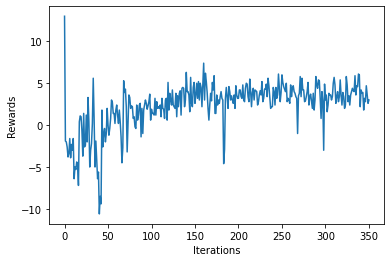

 35%|███████████████████████████                                                  | 3512/10000 [06:02<13:24,  8.06it/s]

Mean Reward = 4.2
0


 35%|███████████████████████████                                                  | 3522/10000 [06:04<13:44,  7.86it/s]

Mean Reward = 3.6
0


 35%|███████████████████████████▏                                                 | 3527/10000 [06:04<12:16,  8.79it/s]

Updated Weights


 35%|███████████████████████████▏                                                 | 3532/10000 [06:05<13:14,  8.14it/s]

Mean Reward = 4.9
1


 35%|███████████████████████████▎                                                 | 3542/10000 [06:06<13:21,  8.05it/s]

Mean Reward = 4.2
0


 36%|███████████████████████████▎                                                 | 3552/10000 [06:07<13:00,  8.26it/s]

Updated Weights
Mean Reward = 4.2
0


 36%|███████████████████████████▍                                                 | 3562/10000 [06:08<12:14,  8.76it/s]

Mean Reward = 6.1
2


 36%|███████████████████████████▌                                                 | 3572/10000 [06:09<11:46,  9.09it/s]

Mean Reward = 4.1
1


 36%|███████████████████████████▌                                                 | 3576/10000 [06:10<11:19,  9.45it/s]

Updated Weights


 36%|███████████████████████████▌                                                 | 3582/10000 [06:10<12:23,  8.63it/s]

Mean Reward = 4.0
1


 36%|███████████████████████████▋                                                 | 3592/10000 [06:12<12:57,  8.24it/s]

Mean Reward = 0.6
0


 36%|███████████████████████████▋                                                 | 3602/10000 [06:13<13:01,  8.18it/s]

Updated Weights
Mean Reward = 2.4
0


 36%|███████████████████████████▊                                                 | 3611/10000 [06:14<11:03,  9.64it/s]

Mean Reward = 4.1
2


 36%|███████████████████████████▉                                                 | 3622/10000 [06:15<13:12,  8.05it/s]

Mean Reward = 3.8
0


 36%|███████████████████████████▉                                                 | 3627/10000 [06:16<11:47,  9.00it/s]

Updated Weights


 36%|███████████████████████████▉                                                 | 3632/10000 [06:16<12:55,  8.22it/s]

Mean Reward = 4.3
1


 36%|████████████████████████████                                                 | 3642/10000 [06:17<13:15,  7.99it/s]

Mean Reward = 2.6
0


 37%|████████████████████████████                                                 | 3652/10000 [06:19<13:03,  8.11it/s]

Updated Weights
Mean Reward = 1.4
0


 37%|████████████████████████████▏                                                | 3662/10000 [06:20<12:41,  8.32it/s]

Mean Reward = 2.8
0


 37%|████████████████████████████▎                                                | 3672/10000 [06:21<13:25,  7.86it/s]

Mean Reward = 3.4
0


 37%|████████████████████████████▎                                                | 3677/10000 [06:22<11:39,  9.04it/s]

Updated Weights


 37%|████████████████████████████▎                                                | 3682/10000 [06:22<12:56,  8.13it/s]

Mean Reward = 4.6
1


 37%|████████████████████████████▍                                                | 3692/10000 [06:24<12:51,  8.18it/s]

Mean Reward = 3.8
0


 37%|████████████████████████████▌                                                | 3702/10000 [06:25<12:24,  8.46it/s]

Updated Weights
Mean Reward = 4.3
1


 37%|████████████████████████████▌                                                | 3712/10000 [06:26<12:55,  8.11it/s]

Mean Reward = 4.7
1


 37%|████████████████████████████▋                                                | 3722/10000 [06:27<13:24,  7.81it/s]

Mean Reward = 2.8
0


 37%|████████████████████████████▋                                                | 3727/10000 [06:28<15:18,  6.83it/s]

Updated Weights


 37%|████████████████████████████▋                                                | 3732/10000 [06:28<13:27,  7.77it/s]

Mean Reward = 4.8
0


 37%|████████████████████████████▊                                                | 3742/10000 [06:30<12:45,  8.17it/s]

Mean Reward = 1.4
0


 38%|████████████████████████████▉                                                | 3752/10000 [06:31<12:55,  8.06it/s]

Updated Weights
Mean Reward = 3.6
0


 38%|████████████████████████████▉                                                | 3762/10000 [06:32<12:36,  8.25it/s]

Mean Reward = 3.0
0


 38%|█████████████████████████████                                                | 3772/10000 [06:33<12:14,  8.47it/s]

Mean Reward = 3.3
1


 38%|█████████████████████████████                                                | 3777/10000 [06:34<12:47,  8.11it/s]

Updated Weights


 38%|█████████████████████████████                                                | 3782/10000 [06:35<12:37,  8.20it/s]

Mean Reward = 3.8
0


 38%|█████████████████████████████▏                                               | 3792/10000 [06:36<12:57,  7.99it/s]

Mean Reward = 3.4
0


 38%|█████████████████████████████▎                                               | 3802/10000 [06:37<11:55,  8.66it/s]

Updated Weights
Mean Reward = 5.1
1


 38%|█████████████████████████████▎                                               | 3812/10000 [06:38<12:36,  8.18it/s]

Mean Reward = 5.4
0


 38%|█████████████████████████████▍                                               | 3822/10000 [06:40<14:22,  7.16it/s]

Mean Reward = 4.0
0


 38%|█████████████████████████████▍                                               | 3827/10000 [06:40<11:57,  8.61it/s]

Updated Weights


 38%|█████████████████████████████▌                                               | 3832/10000 [06:41<12:35,  8.16it/s]

Mean Reward = 4.2
1


 38%|█████████████████████████████▌                                               | 3842/10000 [06:42<11:08,  9.22it/s]

Mean Reward = 5.0
2


 39%|█████████████████████████████▋                                               | 3853/10000 [06:43<10:54,  9.39it/s]

Updated Weights
Mean Reward = 1.2
0


 39%|█████████████████████████████▋                                               | 3862/10000 [06:44<12:16,  8.33it/s]

Mean Reward = 4.0
1


 39%|█████████████████████████████▊                                               | 3872/10000 [06:45<12:45,  8.01it/s]

Mean Reward = 2.2
0


 39%|█████████████████████████████▊                                               | 3877/10000 [06:46<10:58,  9.30it/s]

Updated Weights


 39%|█████████████████████████████▉                                               | 3882/10000 [06:46<12:34,  8.11it/s]

Mean Reward = 3.3
1


 39%|█████████████████████████████▉                                               | 3892/10000 [06:48<12:17,  8.28it/s]

Mean Reward = 2.4
0


 39%|██████████████████████████████                                               | 3902/10000 [06:49<12:00,  8.47it/s]

Updated Weights
Mean Reward = 3.0
1


 39%|██████████████████████████████                                               | 3911/10000 [06:50<10:38,  9.53it/s]

Mean Reward = 4.7
1


 39%|██████████████████████████████▏                                              | 3923/10000 [06:51<10:34,  9.58it/s]

Mean Reward = 5.1
1


 39%|██████████████████████████████▏                                              | 3927/10000 [06:52<11:50,  8.54it/s]

Updated Weights


 39%|██████████████████████████████▎                                              | 3932/10000 [06:52<14:14,  7.10it/s]

Mean Reward = 3.5
1


 39%|██████████████████████████████▎                                              | 3942/10000 [06:53<11:31,  8.76it/s]

Mean Reward = 1.9
1


 40%|██████████████████████████████▍                                              | 3952/10000 [06:54<11:57,  8.43it/s]

Updated Weights
Mean Reward = 3.4
1


 40%|██████████████████████████████▍                                              | 3961/10000 [06:56<12:34,  8.00it/s]

Mean Reward = 3.8
1


 40%|██████████████████████████████▌                                              | 3972/10000 [06:57<14:51,  6.76it/s]

Mean Reward = 3.6
0


 40%|██████████████████████████████▌                                              | 3977/10000 [06:58<15:58,  6.29it/s]

Updated Weights


 40%|██████████████████████████████▋                                              | 3982/10000 [06:59<15:58,  6.28it/s]

Mean Reward = 4.0
0


 40%|██████████████████████████████▋                                              | 3992/10000 [07:00<13:28,  7.43it/s]

Mean Reward = 4.6
1


 40%|██████████████████████████████▊                                              | 4000/10000 [07:01<14:31,  6.88it/s]

Updated Weights
Mean Reward = 3.3
1


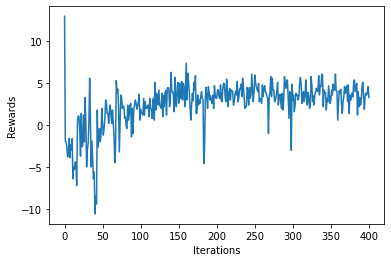

 40%|██████████████████████████████▉                                              | 4012/10000 [07:03<13:35,  7.34it/s]

Mean Reward = 3.3
1


 40%|██████████████████████████████▉                                              | 4022/10000 [07:05<13:12,  7.54it/s]

Mean Reward = 2.0
0


 40%|███████████████████████████████                                              | 4027/10000 [07:05<13:10,  7.55it/s]

Updated Weights


 40%|███████████████████████████████                                              | 4032/10000 [07:06<13:29,  7.37it/s]

Mean Reward = 4.0
0


 40%|███████████████████████████████                                              | 4042/10000 [07:07<12:20,  8.04it/s]

Mean Reward = 4.8
1


 41%|███████████████████████████████▏                                             | 4052/10000 [07:09<15:08,  6.55it/s]

Updated Weights
Mean Reward = 3.4
0


 41%|███████████████████████████████▎                                             | 4062/10000 [07:10<14:47,  6.69it/s]

Mean Reward = 5.9
1


 41%|███████████████████████████████▎                                             | 4072/10000 [07:12<15:58,  6.19it/s]

Mean Reward = 2.8
0


 41%|███████████████████████████████▍                                             | 4078/10000 [07:12<11:46,  8.38it/s]

Updated Weights


 41%|███████████████████████████████▍                                             | 4082/10000 [07:13<15:03,  6.55it/s]

Mean Reward = 6.8
3


 41%|███████████████████████████████▌                                             | 4092/10000 [07:14<12:52,  7.65it/s]

Mean Reward = 5.2
1


 41%|███████████████████████████████▌                                             | 4102/10000 [07:15<12:23,  7.94it/s]

Updated Weights
Mean Reward = 3.9
1


 41%|███████████████████████████████▋                                             | 4112/10000 [07:17<13:09,  7.46it/s]

Mean Reward = 3.9
1


 41%|███████████████████████████████▋                                             | 4122/10000 [07:18<11:29,  8.52it/s]

Mean Reward = 5.3
1


 41%|███████████████████████████████▊                                             | 4127/10000 [07:18<11:24,  8.58it/s]

Updated Weights


 41%|███████████████████████████████▊                                             | 4132/10000 [07:19<13:32,  7.22it/s]

Mean Reward = 4.1
1


 41%|███████████████████████████████▉                                             | 4142/10000 [07:20<10:57,  8.91it/s]

Mean Reward = 6.4
2


 42%|███████████████████████████████▉                                             | 4152/10000 [07:22<13:44,  7.09it/s]

Updated Weights
Mean Reward = 3.6
0


 42%|████████████████████████████████                                             | 4162/10000 [07:23<13:01,  7.47it/s]

Mean Reward = 4.2
0


 42%|████████████████████████████████                                             | 4172/10000 [07:24<11:18,  8.59it/s]

Mean Reward = 4.3
1


 42%|████████████████████████████████▏                                            | 4177/10000 [07:25<13:32,  7.17it/s]

Updated Weights


 42%|████████████████████████████████▏                                            | 4182/10000 [07:26<13:02,  7.44it/s]

Mean Reward = 2.0
0


 42%|████████████████████████████████▎                                            | 4192/10000 [07:27<12:39,  7.65it/s]

Mean Reward = 4.4
0


 42%|████████████████████████████████▎                                            | 4202/10000 [07:28<11:56,  8.10it/s]

Updated Weights
Mean Reward = 3.5
1


 42%|████████████████████████████████▍                                            | 4212/10000 [07:29<10:32,  9.15it/s]

Mean Reward = 5.4
2


 42%|████████████████████████████████▌                                            | 4222/10000 [07:30<10:30,  9.17it/s]

Mean Reward = 3.2
1


 42%|████████████████████████████████▌                                            | 4227/10000 [07:31<12:07,  7.94it/s]

Updated Weights


 42%|████████████████████████████████▌                                            | 4232/10000 [07:32<12:13,  7.87it/s]

Mean Reward = 3.4
0


 42%|████████████████████████████████▋                                            | 4242/10000 [07:33<12:08,  7.90it/s]

Mean Reward = 4.2
0


 43%|████████████████████████████████▋                                            | 4252/10000 [07:34<12:13,  7.84it/s]

Updated Weights
Mean Reward = 4.6
0


 43%|████████████████████████████████▊                                            | 4262/10000 [07:35<13:55,  6.87it/s]

Mean Reward = 3.6
1


 43%|████████████████████████████████▉                                            | 4272/10000 [07:37<13:16,  7.19it/s]

Mean Reward = 3.4
0


 43%|████████████████████████████████▉                                            | 4277/10000 [07:37<12:42,  7.51it/s]

Updated Weights


 43%|████████████████████████████████▉                                            | 4282/10000 [07:38<12:10,  7.83it/s]

Mean Reward = 3.6
0


 43%|█████████████████████████████████                                            | 4292/10000 [07:39<12:06,  7.86it/s]

Mean Reward = 3.0
0


 43%|█████████████████████████████████                                            | 4301/10000 [07:40<09:59,  9.50it/s]

Updated Weights
Mean Reward = 4.9
2


 43%|█████████████████████████████████▏                                           | 4312/10000 [07:42<13:55,  6.81it/s]

Mean Reward = 3.8
0


 43%|█████████████████████████████████▎                                           | 4322/10000 [07:43<12:05,  7.83it/s]

Mean Reward = 3.6
0


 43%|█████████████████████████████████▎                                           | 4327/10000 [07:44<12:07,  7.80it/s]

Updated Weights


 43%|█████████████████████████████████▎                                           | 4332/10000 [07:44<13:01,  7.26it/s]

Mean Reward = 4.0
0


 43%|█████████████████████████████████▍                                           | 4342/10000 [07:46<11:51,  7.95it/s]

Mean Reward = 2.0
0


 44%|█████████████████████████████████▌                                           | 4352/10000 [07:47<12:44,  7.39it/s]

Updated Weights
Mean Reward = 2.6
0


 44%|█████████████████████████████████▌                                           | 4362/10000 [07:48<11:44,  8.00it/s]

Mean Reward = 2.6
0


 44%|█████████████████████████████████▋                                           | 4372/10000 [07:50<12:38,  7.42it/s]

Mean Reward = 4.2
0


 44%|█████████████████████████████████▋                                           | 4377/10000 [07:50<10:43,  8.74it/s]

Updated Weights


 44%|█████████████████████████████████▋                                           | 4382/10000 [07:51<11:42,  7.99it/s]

Mean Reward = 4.3
1


 44%|█████████████████████████████████▊                                           | 4392/10000 [07:52<12:19,  7.59it/s]

Mean Reward = 2.8
0


 44%|█████████████████████████████████▉                                           | 4402/10000 [07:54<13:18,  7.01it/s]

Updated Weights
Mean Reward = 2.8
0


 44%|█████████████████████████████████▉                                           | 4412/10000 [07:55<13:10,  7.07it/s]

Mean Reward = 2.4
0


 44%|██████████████████████████████████                                           | 4421/10000 [07:56<10:40,  8.71it/s]

Mean Reward = 5.1
2


 44%|██████████████████████████████████                                           | 4427/10000 [07:57<11:52,  7.83it/s]

Updated Weights


 44%|██████████████████████████████████▏                                          | 4432/10000 [07:57<11:51,  7.83it/s]

Mean Reward = 3.2
0


 44%|██████████████████████████████████▏                                          | 4443/10000 [07:59<10:08,  9.13it/s]

Mean Reward = 2.4
0


 45%|██████████████████████████████████▎                                          | 4452/10000 [08:00<11:56,  7.74it/s]

Updated Weights
Mean Reward = 5.9
1


 45%|██████████████████████████████████▎                                          | 4463/10000 [08:01<09:21,  9.85it/s]

Mean Reward = 4.9
1


 45%|██████████████████████████████████▍                                          | 4472/10000 [08:02<10:58,  8.40it/s]

Mean Reward = 6.2
2


 45%|██████████████████████████████████▍                                          | 4477/10000 [08:03<10:48,  8.52it/s]

Updated Weights


 45%|██████████████████████████████████▌                                          | 4482/10000 [08:03<11:51,  7.75it/s]

Mean Reward = 4.3
1


 45%|██████████████████████████████████▌                                          | 4492/10000 [08:05<11:53,  7.72it/s]

Mean Reward = 4.4
0


 45%|██████████████████████████████████▋                                          | 4500/10000 [08:05<10:36,  8.64it/s]

Updated Weights
Mean Reward = 4.7
1


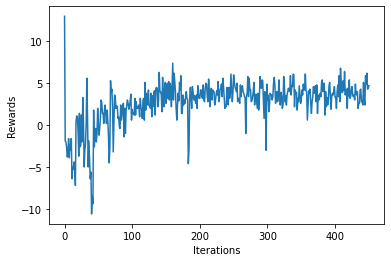

 45%|██████████████████████████████████▋                                          | 4512/10000 [08:07<13:28,  6.79it/s]

Mean Reward = 4.4
0


 45%|██████████████████████████████████▊                                          | 4522/10000 [08:08<10:49,  8.43it/s]

Mean Reward = 4.5
2


 45%|██████████████████████████████████▊                                          | 4527/10000 [08:09<11:45,  7.75it/s]

Updated Weights


 45%|██████████████████████████████████▉                                          | 4533/10000 [08:10<11:08,  8.18it/s]

Mean Reward = 3.2
0


 45%|██████████████████████████████████▉                                          | 4542/10000 [08:11<11:50,  7.69it/s]

Mean Reward = 3.9
1


 46%|███████████████████████████████████                                          | 4552/10000 [08:12<11:26,  7.93it/s]

Updated Weights
Mean Reward = 3.4
0


 46%|███████████████████████████████████▏                                         | 4562/10000 [08:14<12:08,  7.46it/s]

Mean Reward = 3.6
0


 46%|███████████████████████████████████▏                                         | 4572/10000 [08:15<12:21,  7.33it/s]

Mean Reward = 3.6
0


 46%|███████████████████████████████████▏                                         | 4577/10000 [08:16<11:47,  7.66it/s]

Updated Weights


 46%|███████████████████████████████████▎                                         | 4582/10000 [08:16<11:51,  7.61it/s]

Mean Reward = 3.0
0


 46%|███████████████████████████████████▎                                         | 4592/10000 [08:18<11:30,  7.84it/s]

Mean Reward = 3.4
0


 46%|███████████████████████████████████▍                                         | 4602/10000 [08:19<11:12,  8.03it/s]

Updated Weights
Mean Reward = 5.0
1


 46%|███████████████████████████████████▌                                         | 4612/10000 [08:20<10:40,  8.41it/s]

Mean Reward = 4.5
1


 46%|███████████████████████████████████▌                                         | 4622/10000 [08:21<12:55,  6.94it/s]

Mean Reward = 2.8
0


 46%|███████████████████████████████████▋                                         | 4627/10000 [08:22<11:08,  8.04it/s]

Updated Weights


 46%|███████████████████████████████████▋                                         | 4632/10000 [08:23<11:44,  7.62it/s]

Mean Reward = 5.5
1


 46%|███████████████████████████████████▋                                         | 4642/10000 [08:24<11:57,  7.47it/s]

Mean Reward = 5.8
0


 47%|███████████████████████████████████▊                                         | 4652/10000 [08:25<12:17,  7.25it/s]

Updated Weights
Mean Reward = 4.5
1


 47%|███████████████████████████████████▉                                         | 4662/10000 [08:27<11:35,  7.68it/s]

Mean Reward = 3.4
0


 47%|███████████████████████████████████▉                                         | 4672/10000 [08:28<11:51,  7.49it/s]

Mean Reward = 4.0
0


 47%|████████████████████████████████████                                         | 4677/10000 [08:29<13:12,  6.72it/s]

Updated Weights


 47%|████████████████████████████████████                                         | 4682/10000 [08:29<12:02,  7.36it/s]

Mean Reward = 3.6
1


 47%|████████████████████████████████████▏                                        | 4692/10000 [08:31<11:35,  7.63it/s]

Mean Reward = 4.8
0


 47%|████████████████████████████████████▏                                        | 4702/10000 [08:32<12:47,  6.91it/s]

Updated Weights
Mean Reward = 3.3
1


 47%|████████████████████████████████████▎                                        | 4712/10000 [08:33<13:32,  6.51it/s]

Mean Reward = 2.4
0


 47%|████████████████████████████████████▎                                        | 4722/10000 [08:35<10:52,  8.08it/s]

Mean Reward = 4.4
2


 47%|████████████████████████████████████▍                                        | 4728/10000 [08:35<09:43,  9.03it/s]

Updated Weights


 47%|████████████████████████████████████▍                                        | 4732/10000 [08:36<11:14,  7.81it/s]

Mean Reward = 4.0
1


 47%|████████████████████████████████████▌                                        | 4742/10000 [08:37<14:05,  6.22it/s]

Mean Reward = 4.2
0


 48%|████████████████████████████████████▌                                        | 4752/10000 [08:39<11:05,  7.88it/s]

Updated Weights
Mean Reward = 5.0
1


 48%|████████████████████████████████████▋                                        | 4762/10000 [08:40<12:08,  7.19it/s]

Mean Reward = 3.4
0


 48%|████████████████████████████████████▋                                        | 4772/10000 [08:42<13:21,  6.53it/s]

Mean Reward = 1.8
0


 48%|████████████████████████████████████▊                                        | 4777/10000 [08:42<12:28,  6.98it/s]

Updated Weights


 48%|████████████████████████████████████▊                                        | 4782/10000 [08:43<13:01,  6.68it/s]

Mean Reward = 4.4
0


 48%|████████████████████████████████████▉                                        | 4792/10000 [08:45<13:42,  6.33it/s]

Mean Reward = 4.6
0


 48%|████████████████████████████████████▉                                        | 4802/10000 [08:46<12:20,  7.02it/s]

Updated Weights
Mean Reward = 3.9
1


 48%|█████████████████████████████████████                                        | 4812/10000 [08:47<11:17,  7.66it/s]

Mean Reward = 3.0
0


 48%|█████████████████████████████████████▏                                       | 4822/10000 [08:49<11:16,  7.65it/s]

Mean Reward = 3.8
0


 48%|█████████████████████████████████████▏                                       | 4827/10000 [08:49<11:30,  7.49it/s]

Updated Weights


 48%|█████████████████████████████████████▏                                       | 4832/10000 [08:50<09:35,  8.99it/s]

Mean Reward = 3.5
1


 48%|█████████████████████████████████████▎                                       | 4842/10000 [08:51<08:18, 10.36it/s]

Mean Reward = 5.6
1


 49%|█████████████████████████████████████▎                                       | 4852/10000 [08:52<08:16, 10.37it/s]

Updated Weights
Mean Reward = 3.4
0


 49%|█████████████████████████████████████▍                                       | 4863/10000 [08:53<08:42,  9.84it/s]

Mean Reward = 3.2
0


 49%|█████████████████████████████████████▌                                       | 4872/10000 [08:54<08:42,  9.82it/s]

Mean Reward = 4.5
2


 49%|█████████████████████████████████████▌                                       | 4877/10000 [08:54<09:37,  8.87it/s]

Updated Weights


 49%|█████████████████████████████████████▌                                       | 4882/10000 [08:55<10:17,  8.29it/s]

Mean Reward = 5.0
0


 49%|█████████████████████████████████████▋                                       | 4893/10000 [08:56<09:02,  9.42it/s]

Mean Reward = 2.4
0


 49%|█████████████████████████████████████▋                                       | 4901/10000 [08:57<08:50,  9.61it/s]

Updated Weights
Mean Reward = 3.8
0


 49%|█████████████████████████████████████▊                                       | 4911/10000 [08:58<08:35,  9.88it/s]

Mean Reward = 2.0
0


 49%|█████████████████████████████████████▉                                       | 4923/10000 [08:59<07:24, 11.41it/s]

Mean Reward = 4.2
0


 49%|█████████████████████████████████████▉                                       | 4927/10000 [08:59<06:53, 12.26it/s]

Updated Weights


 49%|█████████████████████████████████████▉                                       | 4933/10000 [09:00<07:46, 10.85it/s]

Mean Reward = 5.5
2


 49%|██████████████████████████████████████                                       | 4943/10000 [09:01<07:53, 10.67it/s]

Mean Reward = 3.0
0


 50%|██████████████████████████████████████                                       | 4951/10000 [09:02<08:20, 10.08it/s]

Updated Weights
Mean Reward = 3.8
0


 50%|██████████████████████████████████████▏                                      | 4961/10000 [09:02<07:00, 11.98it/s]

Mean Reward = 3.7
1


 50%|██████████████████████████████████████▎                                      | 4971/10000 [09:03<08:11, 10.23it/s]

Mean Reward = 4.4
0


 50%|██████████████████████████████████████▎                                      | 4977/10000 [09:04<07:56, 10.55it/s]

Updated Weights


 50%|██████████████████████████████████████▎                                      | 4981/10000 [09:04<06:54, 12.09it/s]

Mean Reward = 2.9
1


 50%|██████████████████████████████████████▍                                      | 4993/10000 [09:05<06:34, 12.69it/s]

Mean Reward = 3.2
0


 50%|██████████████████████████████████████▍                                      | 4999/10000 [09:06<07:10, 11.61it/s]

Updated Weights
Mean Reward = 3.6
2


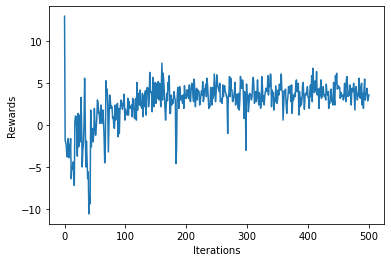

 50%|██████████████████████████████████████▌                                      | 5012/10000 [09:07<09:46,  8.50it/s]

Mean Reward = 0.6
0


 50%|██████████████████████████████████████▋                                      | 5022/10000 [09:08<07:24, 11.21it/s]

Mean Reward = 5.2
3


 50%|██████████████████████████████████████▋                                      | 5026/10000 [09:09<08:47,  9.42it/s]

Updated Weights


 50%|██████████████████████████████████████▊                                      | 5033/10000 [09:10<08:34,  9.66it/s]

Mean Reward = 4.0
0


 50%|██████████████████████████████████████▊                                      | 5041/10000 [09:11<09:42,  8.52it/s]

Mean Reward = 5.2
1


 51%|██████████████████████████████████████▉                                      | 5052/10000 [09:12<09:19,  8.85it/s]

Updated Weights
Mean Reward = 3.4
0


 51%|██████████████████████████████████████▉                                      | 5061/10000 [09:13<07:43, 10.66it/s]

Mean Reward = 4.6
1


 51%|███████████████████████████████████████                                      | 5071/10000 [09:14<07:45, 10.58it/s]

Mean Reward = 2.8
0


 51%|███████████████████████████████████████                                      | 5077/10000 [09:14<07:51, 10.44it/s]

Updated Weights


 51%|███████████████████████████████████████                                      | 5081/10000 [09:14<07:59, 10.26it/s]

Mean Reward = 4.4
1


 51%|███████████████████████████████████████▏                                     | 5092/10000 [09:16<07:50, 10.43it/s]

Mean Reward = 5.1
1


 51%|███████████████████████████████████████▎                                     | 5102/10000 [09:17<08:01, 10.16it/s]

Updated Weights
Mean Reward = 3.4
0


 51%|███████████████████████████████████████▎                                     | 5112/10000 [09:17<06:50, 11.91it/s]

Mean Reward = 2.9
2


 51%|███████████████████████████████████████▍                                     | 5122/10000 [09:18<08:30,  9.55it/s]

Mean Reward = 2.4
0


 51%|███████████████████████████████████████▍                                     | 5127/10000 [09:19<07:53, 10.28it/s]

Updated Weights


 51%|███████████████████████████████████████▌                                     | 5133/10000 [09:19<07:12, 11.27it/s]

Mean Reward = 5.2
1


 51%|███████████████████████████████████████▌                                     | 5141/10000 [09:20<07:37, 10.61it/s]

Mean Reward = 3.6
0


 52%|███████████████████████████████████████▋                                     | 5152/10000 [09:21<07:31, 10.74it/s]

Updated Weights
Mean Reward = 4.8
1


 52%|███████████████████████████████████████▊                                     | 5163/10000 [09:22<07:05, 11.36it/s]

Mean Reward = 4.4
1


 52%|███████████████████████████████████████▊                                     | 5171/10000 [09:23<07:30, 10.72it/s]

Mean Reward = 4.0
0


 52%|███████████████████████████████████████▊                                     | 5177/10000 [09:23<07:24, 10.85it/s]

Updated Weights


 52%|███████████████████████████████████████▉                                     | 5183/10000 [09:24<07:24, 10.84it/s]

Mean Reward = 2.2
0


 52%|███████████████████████████████████████▉                                     | 5193/10000 [09:25<07:30, 10.67it/s]

Mean Reward = 3.4
0


 52%|████████████████████████████████████████                                     | 5202/10000 [09:25<06:27, 12.39it/s]

Updated Weights
Mean Reward = 6.1
2


 52%|████████████████████████████████████████▏                                    | 5212/10000 [09:26<08:17,  9.63it/s]

Mean Reward = 4.1
1


 52%|████████████████████████████████████████▏                                    | 5222/10000 [09:27<07:53, 10.10it/s]

Mean Reward = 2.6
0


 52%|████████████████████████████████████████▎                                    | 5228/10000 [09:28<07:47, 10.20it/s]

Updated Weights


 52%|████████████████████████████████████████▎                                    | 5232/10000 [09:28<07:29, 10.61it/s]

Mean Reward = 6.2
1


 52%|████████████████████████████████████████▎                                    | 5242/10000 [09:29<07:27, 10.62it/s]

Mean Reward = 2.8
0


 53%|████████████████████████████████████████▍                                    | 5252/10000 [09:30<06:52, 11.52it/s]

Updated Weights
Mean Reward = 4.0
1


 53%|████████████████████████████████████████▌                                    | 5262/10000 [09:31<07:33, 10.44it/s]

Mean Reward = 2.8
0


 53%|████████████████████████████████████████▌                                    | 5272/10000 [09:32<07:40, 10.28it/s]

Mean Reward = 6.3
1


 53%|████████████████████████████████████████▋                                    | 5276/10000 [09:32<07:30, 10.49it/s]

Updated Weights


 53%|████████████████████████████████████████▋                                    | 5281/10000 [09:33<08:14,  9.54it/s]

Mean Reward = 3.2
0


 53%|████████████████████████████████████████▋                                    | 5291/10000 [09:34<07:46, 10.08it/s]

Mean Reward = 3.2
0


 53%|████████████████████████████████████████▊                                    | 5303/10000 [09:35<07:52,  9.93it/s]

Updated Weights
Mean Reward = 2.4
0


 53%|████████████████████████████████████████▉                                    | 5311/10000 [09:36<07:44, 10.10it/s]

Mean Reward = 3.5
1


 53%|████████████████████████████████████████▉                                    | 5322/10000 [09:37<07:54,  9.86it/s]

Mean Reward = 5.5
1


 53%|█████████████████████████████████████████                                    | 5326/10000 [09:38<08:34,  9.09it/s]

Updated Weights


 53%|█████████████████████████████████████████                                    | 5333/10000 [09:38<08:18,  9.37it/s]

Mean Reward = 3.2
0


 53%|█████████████████████████████████████████▏                                   | 5342/10000 [09:39<09:02,  8.59it/s]

Mean Reward = 2.8
0


 54%|█████████████████████████████████████████▏                                   | 5353/10000 [09:41<08:30,  9.10it/s]

Updated Weights
Mean Reward = 3.0
0


 54%|█████████████████████████████████████████▎                                   | 5363/10000 [09:42<07:36, 10.16it/s]

Mean Reward = 4.6
0


 54%|█████████████████████████████████████████▎                                   | 5373/10000 [09:42<06:36, 11.66it/s]

Mean Reward = 3.8
2


 54%|█████████████████████████████████████████▍                                   | 5377/10000 [09:43<06:48, 11.33it/s]

Updated Weights


 54%|█████████████████████████████████████████▍                                   | 5381/10000 [09:43<07:00, 10.98it/s]

Mean Reward = 2.2
0


 54%|█████████████████████████████████████████▌                                   | 5393/10000 [09:44<06:46, 11.32it/s]

Mean Reward = 4.4
1


 54%|█████████████████████████████████████████▌                                   | 5401/10000 [09:45<08:02,  9.53it/s]

Updated Weights
Mean Reward = 6.6
0


 54%|█████████████████████████████████████████▋                                   | 5411/10000 [09:46<07:36, 10.05it/s]

Mean Reward = 4.6
0


 54%|█████████████████████████████████████████▋                                   | 5422/10000 [09:47<08:37,  8.84it/s]

Mean Reward = 4.0
0


 54%|█████████████████████████████████████████▊                                   | 5427/10000 [09:48<07:53,  9.65it/s]

Updated Weights


 54%|█████████████████████████████████████████▊                                   | 5432/10000 [09:48<08:34,  8.89it/s]

Mean Reward = 4.5
1


 54%|█████████████████████████████████████████▉                                   | 5442/10000 [09:49<09:30,  7.99it/s]

Mean Reward = 2.4
0


 55%|█████████████████████████████████████████▉                                   | 5452/10000 [09:51<07:47,  9.73it/s]

Updated Weights
Mean Reward = 3.2
0


 55%|██████████████████████████████████████████                                   | 5462/10000 [09:52<07:44,  9.76it/s]

Mean Reward = 3.2
0


 55%|██████████████████████████████████████████▏                                  | 5471/10000 [09:52<07:07, 10.61it/s]

Mean Reward = 4.6
1


 55%|██████████████████████████████████████████▏                                  | 5477/10000 [09:53<07:23, 10.20it/s]

Updated Weights


 55%|██████████████████████████████████████████▏                                  | 5483/10000 [09:54<07:12, 10.45it/s]

Mean Reward = 3.6
0


 55%|██████████████████████████████████████████▎                                  | 5493/10000 [09:55<07:28, 10.04it/s]

Mean Reward = 1.6
0


 55%|██████████████████████████████████████████▎                                  | 5499/10000 [09:55<07:15, 10.34it/s]

Updated Weights
Mean Reward = 2.6
0


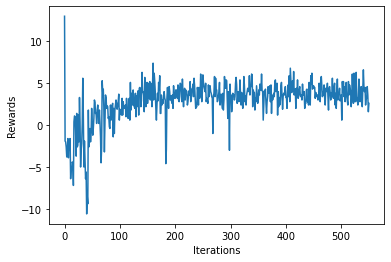

 55%|██████████████████████████████████████████▍                                  | 5513/10000 [09:57<06:45, 11.07it/s]

Mean Reward = 3.8
0


 55%|██████████████████████████████████████████▌                                  | 5523/10000 [09:57<06:26, 11.58it/s]

Mean Reward = 6.5
3


 55%|██████████████████████████████████████████▌                                  | 5527/10000 [09:58<06:46, 11.01it/s]

Updated Weights


 55%|██████████████████████████████████████████▌                                  | 5531/10000 [09:58<06:54, 10.78it/s]

Mean Reward = 4.8
0


 55%|██████████████████████████████████████████▋                                  | 5541/10000 [09:59<07:01, 10.58it/s]

Mean Reward = 1.8
0


 56%|██████████████████████████████████████████▊                                  | 5553/10000 [10:00<06:23, 11.58it/s]

Updated Weights
Mean Reward = 3.5
1


 56%|██████████████████████████████████████████▊                                  | 5561/10000 [10:01<06:44, 10.98it/s]

Mean Reward = 4.4
0


 56%|██████████████████████████████████████████▉                                  | 5573/10000 [10:02<06:03, 12.17it/s]

Mean Reward = 3.2
0


 56%|██████████████████████████████████████████▉                                  | 5577/10000 [10:02<06:59, 10.55it/s]

Updated Weights


 56%|██████████████████████████████████████████▉                                  | 5582/10000 [10:03<08:39,  8.51it/s]

Mean Reward = 3.7
1


 56%|███████████████████████████████████████████                                  | 5593/10000 [10:04<08:54,  8.25it/s]

Mean Reward = 4.1
1


 56%|███████████████████████████████████████████▏                                 | 5602/10000 [10:06<09:21,  7.83it/s]

Updated Weights
Mean Reward = 3.3
1


 56%|███████████████████████████████████████████▏                                 | 5612/10000 [10:07<09:16,  7.89it/s]

Mean Reward = 5.3
2


 56%|███████████████████████████████████████████▎                                 | 5622/10000 [10:08<09:48,  7.44it/s]

Mean Reward = 5.4
2


 56%|███████████████████████████████████████████▎                                 | 5627/10000 [10:09<10:32,  6.92it/s]

Updated Weights


 56%|███████████████████████████████████████████▎                                 | 5632/10000 [10:09<10:02,  7.26it/s]

Mean Reward = 3.2
0


 56%|███████████████████████████████████████████▍                                 | 5642/10000 [10:11<09:09,  7.93it/s]

Mean Reward = 4.0
0


 57%|███████████████████████████████████████████▌                                 | 5652/10000 [10:12<09:31,  7.61it/s]

Updated Weights
Mean Reward = 4.0
0


 57%|███████████████████████████████████████████▌                                 | 5662/10000 [10:13<10:05,  7.16it/s]

Mean Reward = 4.6
0


 57%|███████████████████████████████████████████▋                                 | 5673/10000 [10:15<10:20,  6.98it/s]

Mean Reward = 3.2
0


 57%|███████████████████████████████████████████▋                                 | 5677/10000 [10:16<09:38,  7.47it/s]

Updated Weights


 57%|███████████████████████████████████████████▊                                 | 5682/10000 [10:16<09:24,  7.65it/s]

Mean Reward = 3.8
1


 57%|███████████████████████████████████████████▊                                 | 5691/10000 [10:18<12:13,  5.87it/s]

Mean Reward = 2.8
0


 57%|███████████████████████████████████████████▉                                 | 5701/10000 [10:19<10:15,  6.98it/s]

Updated Weights
Mean Reward = 6.1
1


 57%|███████████████████████████████████████████▉                                 | 5712/10000 [10:21<09:53,  7.22it/s]

Mean Reward = 4.1
1


 57%|████████████████████████████████████████████                                 | 5722/10000 [10:22<10:19,  6.91it/s]

Mean Reward = 4.6
0


 57%|████████████████████████████████████████████                                 | 5727/10000 [10:23<09:47,  7.27it/s]

Updated Weights


 57%|████████████████████████████████████████████▏                                | 5732/10000 [10:23<08:49,  8.07it/s]

Mean Reward = 1.9
1


 57%|████████████████████████████████████████████▏                                | 5742/10000 [10:25<09:21,  7.59it/s]

Mean Reward = 2.4
0


 58%|████████████████████████████████████████████▎                                | 5752/10000 [10:26<09:43,  7.28it/s]

Updated Weights
Mean Reward = 2.2
0


 58%|████████████████████████████████████████████▎                                | 5762/10000 [10:27<09:42,  7.28it/s]

Mean Reward = 4.0
0


 58%|████████████████████████████████████████████▍                                | 5772/10000 [10:29<10:01,  7.02it/s]

Mean Reward = 2.7
1


 58%|████████████████████████████████████████████▍                                | 5777/10000 [10:29<11:02,  6.37it/s]

Updated Weights


 58%|████████████████████████████████████████████▌                                | 5782/10000 [10:30<10:55,  6.43it/s]

Mean Reward = 4.2
0


 58%|████████████████████████████████████████████▌                                | 5792/10000 [10:32<09:15,  7.58it/s]

Mean Reward = 6.5
1


 58%|████████████████████████████████████████████▋                                | 5802/10000 [10:33<10:57,  6.39it/s]

Updated Weights
Mean Reward = 2.2
0


 58%|████████████████████████████████████████████▊                                | 5812/10000 [10:34<10:06,  6.90it/s]

Mean Reward = 2.9
1


 58%|████████████████████████████████████████████▊                                | 5822/10000 [10:36<09:02,  7.71it/s]

Mean Reward = 4.8
2


 58%|████████████████████████████████████████████▊                                | 5827/10000 [10:37<11:51,  5.86it/s]

Updated Weights


 58%|████████████████████████████████████████████▉                                | 5832/10000 [10:37<10:57,  6.34it/s]

Mean Reward = 2.6
0


 58%|████████████████████████████████████████████▉                                | 5842/10000 [10:39<10:25,  6.65it/s]

Mean Reward = 3.7
1


 59%|█████████████████████████████████████████████                                | 5852/10000 [10:40<10:48,  6.40it/s]

Updated Weights
Mean Reward = 3.4
0


 59%|█████████████████████████████████████████████▏                               | 5862/10000 [10:42<11:23,  6.06it/s]

Mean Reward = 2.6
0


 59%|█████████████████████████████████████████████▏                               | 5872/10000 [10:43<10:07,  6.80it/s]

Mean Reward = 3.8
0


 59%|█████████████████████████████████████████████▎                               | 5877/10000 [10:44<10:06,  6.79it/s]

Updated Weights


 59%|█████████████████████████████████████████████▎                               | 5882/10000 [10:45<10:28,  6.56it/s]

Mean Reward = 4.4
0


 59%|█████████████████████████████████████████████▎                               | 5892/10000 [10:46<10:04,  6.79it/s]

Mean Reward = 5.0
0


 59%|█████████████████████████████████████████████▍                               | 5902/10000 [10:48<10:13,  6.67it/s]

Updated Weights
Mean Reward = 3.2
1


 59%|█████████████████████████████████████████████▌                               | 5912/10000 [10:49<10:32,  6.47it/s]

Mean Reward = 3.8
0


 59%|█████████████████████████████████████████████▌                               | 5922/10000 [10:51<09:47,  6.94it/s]

Mean Reward = 2.4
1


 59%|█████████████████████████████████████████████▋                               | 5927/10000 [10:51<09:49,  6.91it/s]

Updated Weights


 59%|█████████████████████████████████████████████▋                               | 5932/10000 [10:52<09:10,  7.39it/s]

Mean Reward = 2.7
1


 59%|█████████████████████████████████████████████▊                               | 5942/10000 [10:54<09:58,  6.77it/s]

Mean Reward = 1.8
0


 60%|█████████████████████████████████████████████▊                               | 5952/10000 [10:55<10:28,  6.45it/s]

Updated Weights
Mean Reward = 3.2
0


 60%|█████████████████████████████████████████████▉                               | 5962/10000 [10:56<09:43,  6.92it/s]

Mean Reward = 4.4
1


 60%|█████████████████████████████████████████████▉                               | 5972/10000 [10:58<10:32,  6.37it/s]

Mean Reward = 3.2
0


 60%|██████████████████████████████████████████████                               | 5977/10000 [10:59<10:31,  6.37it/s]

Updated Weights


 60%|██████████████████████████████████████████████                               | 5982/10000 [11:00<09:55,  6.75it/s]

Mean Reward = 3.8
0


 60%|██████████████████████████████████████████████▏                              | 5992/10000 [11:01<10:37,  6.29it/s]

Mean Reward = 2.0
0


 60%|██████████████████████████████████████████████▏                              | 6000/10000 [11:02<09:15,  7.21it/s]

Updated Weights
Mean Reward = 4.9
1


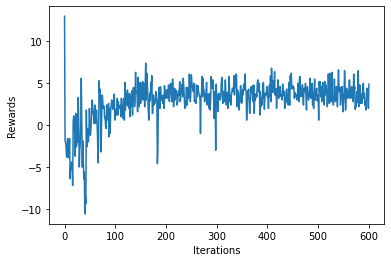

 60%|██████████████████████████████████████████████▎                              | 6012/10000 [11:04<09:00,  7.38it/s]

Mean Reward = 6.1
1


 60%|██████████████████████████████████████████████▎                              | 6022/10000 [11:06<10:19,  6.42it/s]

Mean Reward = 4.5
1


 60%|██████████████████████████████████████████████▍                              | 6027/10000 [11:06<08:54,  7.44it/s]

Updated Weights


 60%|██████████████████████████████████████████████▍                              | 6032/10000 [11:07<10:02,  6.59it/s]

Mean Reward = 3.9
1


 60%|██████████████████████████████████████████████▌                              | 6042/10000 [11:08<10:04,  6.55it/s]

Mean Reward = 5.0
0


 61%|██████████████████████████████████████████████▌                              | 6052/10000 [11:10<09:54,  6.64it/s]

Updated Weights
Mean Reward = 3.8
1


 61%|██████████████████████████████████████████████▋                              | 6062/10000 [11:11<09:48,  6.69it/s]

Mean Reward = 2.6
0


 61%|██████████████████████████████████████████████▊                              | 6072/10000 [11:13<08:48,  7.43it/s]

Mean Reward = 4.0
1


 61%|██████████████████████████████████████████████▊                              | 6077/10000 [11:13<09:30,  6.88it/s]

Updated Weights


 61%|██████████████████████████████████████████████▊                              | 6082/10000 [11:14<08:48,  7.41it/s]

Mean Reward = 4.9
1


 61%|██████████████████████████████████████████████▉                              | 6092/10000 [11:16<09:00,  7.23it/s]

Mean Reward = 3.7
1


 61%|██████████████████████████████████████████████▉                              | 6102/10000 [11:17<09:35,  6.77it/s]

Updated Weights
Mean Reward = 3.6
0


 61%|███████████████████████████████████████████████                              | 6112/10000 [11:18<09:44,  6.65it/s]

Mean Reward = 2.4
0


 61%|███████████████████████████████████████████████▏                             | 6122/10000 [11:20<09:43,  6.65it/s]

Mean Reward = 2.2
0


 61%|███████████████████████████████████████████████▏                             | 6127/10000 [11:21<09:37,  6.70it/s]

Updated Weights


 61%|███████████████████████████████████████████████▏                             | 6132/10000 [11:21<08:53,  7.25it/s]

Mean Reward = 4.3
1


 61%|███████████████████████████████████████████████▎                             | 6142/10000 [11:23<09:05,  7.07it/s]

Mean Reward = 4.1
1


 62%|███████████████████████████████████████████████▎                             | 6152/10000 [11:24<09:37,  6.67it/s]

Updated Weights
Mean Reward = 4.7
1


 62%|███████████████████████████████████████████████▍                             | 6162/10000 [11:25<09:18,  6.87it/s]

Mean Reward = 4.0
2


 62%|███████████████████████████████████████████████▌                             | 6172/10000 [11:27<08:34,  7.45it/s]

Mean Reward = 5.1
2


 62%|███████████████████████████████████████████████▌                             | 6177/10000 [11:27<09:53,  6.44it/s]

Updated Weights


 62%|███████████████████████████████████████████████▌                             | 6182/10000 [11:28<09:11,  6.92it/s]

Mean Reward = 4.1
1


 62%|███████████████████████████████████████████████▋                             | 6192/10000 [11:30<10:06,  6.28it/s]

Mean Reward = 4.4
0


 62%|███████████████████████████████████████████████▊                             | 6202/10000 [11:31<09:21,  6.77it/s]

Updated Weights
Mean Reward = 3.8
0


 62%|███████████████████████████████████████████████▊                             | 6212/10000 [11:33<09:43,  6.49it/s]

Mean Reward = 3.4
0


 62%|███████████████████████████████████████████████▉                             | 6222/10000 [11:34<09:21,  6.73it/s]

Mean Reward = 2.4
0


 62%|███████████████████████████████████████████████▉                             | 6226/10000 [11:35<10:34,  5.95it/s]

Updated Weights


 62%|███████████████████████████████████████████████▉                             | 6232/10000 [11:36<09:54,  6.33it/s]

Mean Reward = 3.2
1


 62%|████████████████████████████████████████████████                             | 6242/10000 [11:37<08:54,  7.02it/s]

Mean Reward = 4.0
2


 63%|████████████████████████████████████████████████▏                            | 6252/10000 [11:39<09:55,  6.29it/s]

Updated Weights
Mean Reward = 2.6
0


 63%|████████████████████████████████████████████████▏                            | 6263/10000 [11:40<08:08,  7.65it/s]

Mean Reward = 4.2
1


 63%|████████████████████████████████████████████████▎                            | 6272/10000 [11:41<09:21,  6.64it/s]

Mean Reward = 3.6
1


 63%|████████████████████████████████████████████████▎                            | 6277/10000 [11:42<08:49,  7.03it/s]

Updated Weights


 63%|████████████████████████████████████████████████▍                            | 6283/10000 [11:43<08:11,  7.57it/s]

Mean Reward = 4.0
1


 63%|████████████████████████████████████████████████▍                            | 6292/10000 [11:44<08:44,  7.07it/s]

Mean Reward = 5.1
2


 63%|████████████████████████████████████████████████▌                            | 6301/10000 [11:45<09:13,  6.68it/s]

Updated Weights
Mean Reward = 5.4
1


 63%|████████████████████████████████████████████████▌                            | 6312/10000 [11:47<08:54,  6.91it/s]

Mean Reward = 5.5
2


 63%|████████████████████████████████████████████████▋                            | 6322/10000 [11:48<07:46,  7.88it/s]

Mean Reward = 4.2
2


 63%|████████████████████████████████████████████████▋                            | 6327/10000 [11:49<08:46,  6.97it/s]

Updated Weights


 63%|████████████████████████████████████████████████▊                            | 6332/10000 [11:49<09:10,  6.66it/s]

Mean Reward = 2.8
0


 63%|████████████████████████████████████████████████▊                            | 6342/10000 [11:51<08:02,  7.59it/s]

Mean Reward = 5.9
2


 64%|████████████████████████████████████████████████▉                            | 6352/10000 [11:52<09:11,  6.62it/s]

Updated Weights
Mean Reward = 4.4
0


 64%|████████████████████████████████████████████████▉                            | 6362/10000 [11:54<08:49,  6.87it/s]

Mean Reward = 5.3
1


 64%|█████████████████████████████████████████████████                            | 6372/10000 [11:55<08:57,  6.74it/s]

Mean Reward = 2.6
0


 64%|█████████████████████████████████████████████████                            | 6377/10000 [11:56<08:30,  7.10it/s]

Updated Weights


 64%|█████████████████████████████████████████████████▏                           | 6382/10000 [11:56<09:18,  6.48it/s]

Mean Reward = 5.5
2


 64%|█████████████████████████████████████████████████▏                           | 6392/10000 [11:58<09:17,  6.47it/s]

Mean Reward = 6.0
1


 64%|█████████████████████████████████████████████████▎                           | 6403/10000 [11:59<07:52,  7.62it/s]

Updated Weights
Mean Reward = 2.4
0


 64%|█████████████████████████████████████████████████▎                           | 6412/10000 [12:01<08:22,  7.15it/s]

Mean Reward = 6.2
2


 64%|█████████████████████████████████████████████████▍                           | 6422/10000 [12:02<09:07,  6.54it/s]

Mean Reward = 2.5
1


 64%|█████████████████████████████████████████████████▍                           | 6427/10000 [12:03<09:15,  6.44it/s]

Updated Weights


 64%|█████████████████████████████████████████████████▌                           | 6432/10000 [12:03<08:16,  7.18it/s]

Mean Reward = 3.6
1


 64%|█████████████████████████████████████████████████▌                           | 6442/10000 [12:05<07:46,  7.62it/s]

Mean Reward = 4.3
1


 65%|█████████████████████████████████████████████████▋                           | 6452/10000 [12:06<08:52,  6.67it/s]

Updated Weights
Mean Reward = 2.4
0


 65%|█████████████████████████████████████████████████▊                           | 6462/10000 [12:08<09:31,  6.20it/s]

Mean Reward = 4.2
1


 65%|█████████████████████████████████████████████████▊                           | 6472/10000 [12:09<08:58,  6.55it/s]

Mean Reward = -0.4
0


 65%|█████████████████████████████████████████████████▊                           | 6477/10000 [12:10<09:20,  6.29it/s]

Updated Weights


 65%|█████████████████████████████████████████████████▉                           | 6482/10000 [12:11<08:40,  6.76it/s]

Mean Reward = -4.4
0


 65%|█████████████████████████████████████████████████▉                           | 6492/10000 [12:12<08:39,  6.75it/s]

Mean Reward = 5.7
1


 65%|██████████████████████████████████████████████████                           | 6500/10000 [12:13<08:42,  6.70it/s]

Updated Weights
Mean Reward = 1.9
1


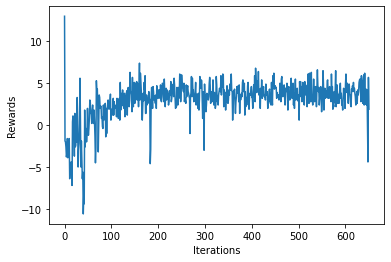

 65%|██████████████████████████████████████████████████▏                          | 6512/10000 [12:16<08:37,  6.74it/s]

Mean Reward = 0.6
0


 65%|██████████████████████████████████████████████████▏                          | 6522/10000 [12:17<08:51,  6.55it/s]

Mean Reward = 3.4
0


 65%|██████████████████████████████████████████████████▎                          | 6527/10000 [12:18<07:42,  7.51it/s]

Updated Weights


 65%|██████████████████████████████████████████████████▎                          | 6532/10000 [12:18<08:17,  6.98it/s]

Mean Reward = 3.7
1


 65%|██████████████████████████████████████████████████▎                          | 6542/10000 [12:20<08:47,  6.55it/s]

Mean Reward = 3.8
0


 66%|██████████████████████████████████████████████████▍                          | 6552/10000 [12:21<09:00,  6.38it/s]

Updated Weights
Mean Reward = -1.8
0


 66%|██████████████████████████████████████████████████▌                          | 6562/10000 [12:23<09:00,  6.36it/s]

Mean Reward = 2.6
0


 66%|██████████████████████████████████████████████████▌                          | 6572/10000 [12:24<08:20,  6.84it/s]

Mean Reward = -0.8
1


 66%|██████████████████████████████████████████████████▋                          | 6577/10000 [12:25<09:31,  5.99it/s]

Updated Weights


 66%|██████████████████████████████████████████████████▋                          | 6582/10000 [12:26<08:56,  6.37it/s]

Mean Reward = 2.0
0


 66%|██████████████████████████████████████████████████▊                          | 6592/10000 [12:27<08:29,  6.69it/s]

Mean Reward = 2.8
0


 66%|██████████████████████████████████████████████████▊                          | 6601/10000 [12:29<08:21,  6.78it/s]

Updated Weights
Mean Reward = 3.2
1


 66%|██████████████████████████████████████████████████▉                          | 6612/10000 [12:30<07:52,  7.17it/s]

Mean Reward = 2.9
1


 66%|██████████████████████████████████████████████████▉                          | 6621/10000 [12:32<12:36,  4.47it/s]

Mean Reward = 4.2
0


 66%|███████████████████████████████████████████████████                          | 6626/10000 [12:33<11:49,  4.76it/s]

Updated Weights


 66%|███████████████████████████████████████████████████                          | 6631/10000 [12:34<10:00,  5.61it/s]

Mean Reward = 5.1
1


 66%|███████████████████████████████████████████████████▏                         | 6642/10000 [12:36<10:06,  5.54it/s]

Mean Reward = 3.0
0


 67%|███████████████████████████████████████████████████▏                         | 6652/10000 [12:38<09:22,  5.95it/s]

Updated Weights
Mean Reward = 3.2
0


 67%|███████████████████████████████████████████████████▎                         | 6661/10000 [12:39<09:50,  5.65it/s]

Mean Reward = 5.4
1


 67%|███████████████████████████████████████████████████▎                         | 6671/10000 [12:41<11:35,  4.79it/s]

Mean Reward = 3.4
0


 67%|███████████████████████████████████████████████████▍                         | 6677/10000 [12:42<10:22,  5.33it/s]

Updated Weights


 67%|███████████████████████████████████████████████████▍                         | 6681/10000 [12:43<09:54,  5.58it/s]

Mean Reward = 4.6
0


 67%|███████████████████████████████████████████████████▌                         | 6692/10000 [12:45<07:44,  7.13it/s]

Mean Reward = 3.0
0


 67%|███████████████████████████████████████████████████▌                         | 6702/10000 [12:46<07:21,  7.47it/s]

Updated Weights
Mean Reward = 3.2
0


 67%|███████████████████████████████████████████████████▋                         | 6712/10000 [12:47<07:07,  7.68it/s]

Mean Reward = 4.2
0


 67%|███████████████████████████████████████████████████▊                         | 6722/10000 [12:49<07:04,  7.73it/s]

Mean Reward = 2.0
0


 67%|███████████████████████████████████████████████████▊                         | 6727/10000 [12:49<07:06,  7.67it/s]

Updated Weights


 67%|███████████████████████████████████████████████████▊                         | 6732/10000 [12:50<06:33,  8.30it/s]

Mean Reward = 3.2
1


 67%|███████████████████████████████████████████████████▉                         | 6742/10000 [12:51<06:54,  7.86it/s]

Mean Reward = 2.4
0


 68%|███████████████████████████████████████████████████▉                         | 6752/10000 [12:52<06:44,  8.03it/s]

Updated Weights
Mean Reward = 2.6
0


 68%|████████████████████████████████████████████████████                         | 6762/10000 [12:53<05:33,  9.70it/s]

Mean Reward = 6.4
3


 68%|████████████████████████████████████████████████████▏                        | 6772/10000 [12:55<06:59,  7.70it/s]

Mean Reward = 2.6
0


 68%|████████████████████████████████████████████████████▏                        | 6777/10000 [12:55<07:09,  7.50it/s]

Updated Weights


 68%|████████████████████████████████████████████████████▏                        | 6782/10000 [12:56<06:45,  7.94it/s]

Mean Reward = 4.7
1


 68%|████████████████████████████████████████████████████▎                        | 6792/10000 [12:57<06:54,  7.73it/s]

Mean Reward = 3.8
0


 68%|████████████████████████████████████████████████████▍                        | 6802/10000 [12:59<06:47,  7.84it/s]

Updated Weights
Mean Reward = 4.4
0


 68%|████████████████████████████████████████████████████▍                        | 6814/10000 [13:00<05:16, 10.07it/s]

Mean Reward = 4.9
1


 68%|████████████████████████████████████████████████████▌                        | 6822/10000 [13:01<06:41,  7.91it/s]

Mean Reward = 5.5
2


 68%|████████████████████████████████████████████████████▌                        | 6826/10000 [13:02<09:40,  5.47it/s]

Updated Weights


 68%|████████████████████████████████████████████████████▌                        | 6831/10000 [13:02<09:54,  5.33it/s]

Mean Reward = 3.2
0


 68%|████████████████████████████████████████████████████▋                        | 6842/10000 [13:04<08:27,  6.22it/s]

Mean Reward = 4.1
1


 69%|████████████████████████████████████████████████████▊                        | 6852/10000 [13:06<08:58,  5.85it/s]

Updated Weights
Mean Reward = 4.6
1


 69%|████████████████████████████████████████████████████▊                        | 6862/10000 [13:07<08:15,  6.34it/s]

Mean Reward = 5.9
1


 69%|████████████████████████████████████████████████████▉                        | 6871/10000 [13:09<09:28,  5.51it/s]

Mean Reward = 4.1
1


 69%|████████████████████████████████████████████████████▉                        | 6876/10000 [13:10<09:56,  5.24it/s]

Updated Weights


 69%|████████████████████████████████████████████████████▉                        | 6881/10000 [13:11<08:44,  5.94it/s]

Mean Reward = 4.2
1


 69%|█████████████████████████████████████████████████████                        | 6892/10000 [13:12<08:13,  6.30it/s]

Mean Reward = 3.6
0


 69%|█████████████████████████████████████████████████████▏                       | 6902/10000 [13:14<07:34,  6.82it/s]

Updated Weights
Mean Reward = 2.0
0


 69%|█████████████████████████████████████████████████████▏                       | 6912/10000 [13:15<07:56,  6.48it/s]

Mean Reward = 4.2
0


 69%|█████████████████████████████████████████████████████▎                       | 6922/10000 [13:17<09:24,  5.45it/s]

Mean Reward = 2.2
0


 69%|█████████████████████████████████████████████████████▎                       | 6926/10000 [13:18<10:49,  4.74it/s]

Updated Weights


 69%|█████████████████████████████████████████████████████▎                       | 6931/10000 [13:19<09:52,  5.18it/s]

Mean Reward = 3.8
0


 69%|█████████████████████████████████████████████████████▍                       | 6942/10000 [13:21<08:28,  6.01it/s]

Mean Reward = 4.3
1


 70%|█████████████████████████████████████████████████████▌                       | 6952/10000 [13:23<08:55,  5.70it/s]

Updated Weights
Mean Reward = 4.6
0


 70%|█████████████████████████████████████████████████████▌                       | 6962/10000 [13:24<07:45,  6.53it/s]

Mean Reward = 3.2
0


 70%|█████████████████████████████████████████████████████▋                       | 6972/10000 [13:25<07:08,  7.06it/s]

Mean Reward = 2.3
1


 70%|█████████████████████████████████████████████████████▋                       | 6977/10000 [13:26<07:25,  6.79it/s]

Updated Weights


 70%|█████████████████████████████████████████████████████▊                       | 6981/10000 [13:27<08:06,  6.21it/s]

Mean Reward = 2.4
0


 70%|█████████████████████████████████████████████████████▊                       | 6991/10000 [13:29<09:26,  5.32it/s]

Mean Reward = 3.0
0


 70%|█████████████████████████████████████████████████████▉                       | 7000/10000 [13:30<08:48,  5.67it/s]

Updated Weights
Mean Reward = 3.0
0


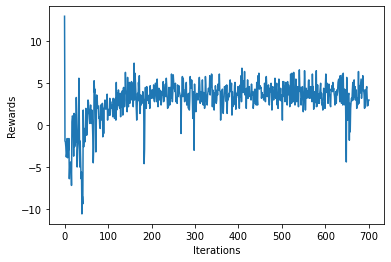

 70%|█████████████████████████████████████████████████████▉                       | 7012/10000 [13:33<08:13,  6.06it/s]

Mean Reward = 5.7
1


 70%|██████████████████████████████████████████████████████                       | 7022/10000 [13:34<07:21,  6.74it/s]

Mean Reward = 2.4
0


 70%|██████████████████████████████████████████████████████                       | 7027/10000 [13:35<07:02,  7.04it/s]

Updated Weights


 70%|██████████████████████████████████████████████████████▏                      | 7031/10000 [13:35<07:51,  6.30it/s]

Mean Reward = 4.7
2


 70%|██████████████████████████████████████████████████████▏                      | 7042/10000 [13:37<08:26,  5.83it/s]

Mean Reward = 2.2
0


 71%|██████████████████████████████████████████████████████▎                      | 7053/10000 [13:39<06:21,  7.72it/s]

Updated Weights
Mean Reward = 1.6
0


 71%|██████████████████████████████████████████████████████▎                      | 7061/10000 [13:40<08:18,  5.89it/s]

Mean Reward = 3.9
1


 71%|██████████████████████████████████████████████████████▍                      | 7072/10000 [13:42<08:30,  5.74it/s]

Mean Reward = 3.6
0


 71%|██████████████████████████████████████████████████████▍                      | 7075/10000 [13:43<08:35,  5.68it/s]

Updated Weights


 71%|██████████████████████████████████████████████████████▌                      | 7082/10000 [13:44<07:25,  6.56it/s]

Mean Reward = 3.1
1


 71%|██████████████████████████████████████████████████████▌                      | 7091/10000 [13:45<08:22,  5.79it/s]

Mean Reward = 3.5
1


 71%|██████████████████████████████████████████████████████▋                      | 7102/10000 [13:47<07:09,  6.75it/s]

Updated Weights
Mean Reward = 5.6
0


 71%|██████████████████████████████████████████████████████▊                      | 7111/10000 [13:48<07:52,  6.12it/s]

Mean Reward = 3.6
0


 71%|██████████████████████████████████████████████████████▊                      | 7121/10000 [13:50<09:20,  5.13it/s]

Mean Reward = 2.2
0


 71%|██████████████████████████████████████████████████████▊                      | 7126/10000 [13:51<09:02,  5.30it/s]

Updated Weights


 71%|██████████████████████████████████████████████████████▉                      | 7131/10000 [13:52<08:21,  5.72it/s]

Mean Reward = 4.6
2


 71%|██████████████████████████████████████████████████████▉                      | 7141/10000 [13:53<09:08,  5.21it/s]

Mean Reward = 5.5
1


 72%|███████████████████████████████████████████████████████                      | 7152/10000 [13:55<07:05,  6.70it/s]

Updated Weights
Mean Reward = 5.2
0


 72%|███████████████████████████████████████████████████████▏                     | 7162/10000 [13:57<07:15,  6.52it/s]

Mean Reward = 2.8
0


 72%|███████████████████████████████████████████████████████▏                     | 7171/10000 [13:58<08:08,  5.79it/s]

Mean Reward = 4.3
1


 72%|███████████████████████████████████████████████████████▎                     | 7177/10000 [13:59<07:56,  5.92it/s]

Updated Weights


 72%|███████████████████████████████████████████████████████▎                     | 7182/10000 [14:00<06:53,  6.82it/s]

Mean Reward = 3.2
0


 72%|███████████████████████████████████████████████████████▍                     | 7192/10000 [14:01<06:46,  6.90it/s]

Mean Reward = 4.1
1


 72%|███████████████████████████████████████████████████████▍                     | 7202/10000 [14:03<07:25,  6.28it/s]

Updated Weights
Mean Reward = 2.6
0


 72%|███████████████████████████████████████████████████████▌                     | 7212/10000 [14:04<07:11,  6.46it/s]

Mean Reward = 4.4
0


 72%|███████████████████████████████████████████████████████▌                     | 7222/10000 [14:06<07:32,  6.14it/s]

Mean Reward = 1.2
0


 72%|███████████████████████████████████████████████████████▋                     | 7226/10000 [14:06<06:36,  7.00it/s]

Updated Weights


 72%|███████████████████████████████████████████████████████▋                     | 7232/10000 [14:07<05:52,  7.85it/s]

Mean Reward = 6.2
3


 72%|███████████████████████████████████████████████████████▊                     | 7242/10000 [14:09<07:37,  6.03it/s]

Mean Reward = 4.4
1


 73%|███████████████████████████████████████████████████████▊                     | 7251/10000 [14:10<08:27,  5.42it/s]

Updated Weights
Mean Reward = 3.2
0


 73%|███████████████████████████████████████████████████████▉                     | 7261/10000 [14:12<09:04,  5.03it/s]

Mean Reward = 3.8
0


 73%|███████████████████████████████████████████████████████▉                     | 7271/10000 [14:14<08:56,  5.09it/s]

Mean Reward = 4.0
0


 73%|████████████████████████████████████████████████████████                     | 7276/10000 [14:15<09:08,  4.97it/s]

Updated Weights


 73%|████████████████████████████████████████████████████████                     | 7281/10000 [14:16<09:06,  4.97it/s]

Mean Reward = 3.2
0


 73%|████████████████████████████████████████████████████████▏                    | 7291/10000 [14:18<09:52,  4.57it/s]

Mean Reward = 3.2
0


 73%|████████████████████████████████████████████████████████▏                    | 7301/10000 [14:20<08:46,  5.12it/s]

Updated Weights
Mean Reward = 3.8
0


 73%|████████████████████████████████████████████████████████▎                    | 7311/10000 [14:22<08:55,  5.02it/s]

Mean Reward = 2.6
0


 73%|████████████████████████████████████████████████████████▎                    | 7321/10000 [14:24<08:19,  5.36it/s]

Mean Reward = 2.4
0


 73%|████████████████████████████████████████████████████████▍                    | 7327/10000 [14:25<07:24,  6.02it/s]

Updated Weights


 73%|████████████████████████████████████████████████████████▍                    | 7332/10000 [14:26<06:20,  7.00it/s]

Mean Reward = 4.0
1


 73%|████████████████████████████████████████████████████████▌                    | 7341/10000 [14:28<09:57,  4.45it/s]

Mean Reward = 2.6
0


 74%|████████████████████████████████████████████████████████▌                    | 7351/10000 [14:30<09:54,  4.46it/s]

Updated Weights
Mean Reward = 3.0
0


 74%|████████████████████████████████████████████████████████▋                    | 7362/10000 [14:32<06:05,  7.22it/s]

Mean Reward = 3.0
0


 74%|████████████████████████████████████████████████████████▊                    | 7372/10000 [14:33<05:02,  8.68it/s]

Mean Reward = 5.0
2


 74%|████████████████████████████████████████████████████████▊                    | 7377/10000 [14:33<04:59,  8.76it/s]

Updated Weights


 74%|████████████████████████████████████████████████████████▊                    | 7382/10000 [14:34<05:32,  7.87it/s]

Mean Reward = 4.5
2


 74%|████████████████████████████████████████████████████████▉                    | 7393/10000 [14:35<04:42,  9.22it/s]

Mean Reward = 2.8
0


 74%|████████████████████████████████████████████████████████▉                    | 7402/10000 [14:36<05:38,  7.68it/s]

Updated Weights
Mean Reward = 3.8
1


 74%|█████████████████████████████████████████████████████████                    | 7412/10000 [14:38<07:01,  6.14it/s]

Mean Reward = 4.4
0


 74%|█████████████████████████████████████████████████████████▏                   | 7422/10000 [14:40<08:01,  5.35it/s]

Mean Reward = 1.8
0


 74%|█████████████████████████████████████████████████████████▏                   | 7428/10000 [14:41<06:00,  7.14it/s]

Updated Weights


 74%|█████████████████████████████████████████████████████████▏                   | 7433/10000 [14:41<05:03,  8.45it/s]

Mean Reward = 4.8
2


 74%|█████████████████████████████████████████████████████████▎                   | 7442/10000 [14:42<05:53,  7.24it/s]

Mean Reward = 2.8
1


 75%|█████████████████████████████████████████████████████████▍                   | 7452/10000 [14:44<05:44,  7.40it/s]

Updated Weights
Mean Reward = 4.4
0


 75%|█████████████████████████████████████████████████████████▍                   | 7462/10000 [14:45<05:22,  7.86it/s]

Mean Reward = 3.1
1


 75%|█████████████████████████████████████████████████████████▌                   | 7472/10000 [14:46<05:20,  7.88it/s]

Mean Reward = 3.2
0


 75%|█████████████████████████████████████████████████████████▌                   | 7477/10000 [14:47<05:15,  8.00it/s]

Updated Weights


 75%|█████████████████████████████████████████████████████████▋                   | 7484/10000 [14:47<04:32,  9.23it/s]

Mean Reward = 3.0
0


 75%|█████████████████████████████████████████████████████████▋                   | 7492/10000 [14:49<05:44,  7.29it/s]

Mean Reward = 6.2
2


 75%|█████████████████████████████████████████████████████████▊                   | 7500/10000 [14:50<05:21,  7.78it/s]

Updated Weights
Mean Reward = 3.6
0


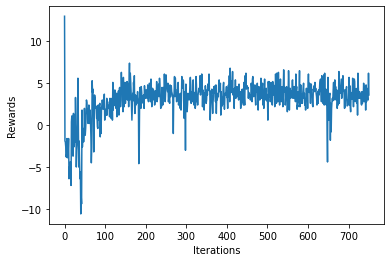

 75%|█████████████████████████████████████████████████████████▊                   | 7512/10000 [14:51<05:39,  7.32it/s]

Mean Reward = 2.4
0


 75%|█████████████████████████████████████████████████████████▉                   | 7523/10000 [14:53<04:31,  9.11it/s]

Mean Reward = 6.7
1


 75%|█████████████████████████████████████████████████████████▉                   | 7527/10000 [14:53<04:10,  9.88it/s]

Updated Weights


 75%|█████████████████████████████████████████████████████████▉                   | 7532/10000 [14:54<05:11,  7.92it/s]

Mean Reward = 4.0
2


 75%|██████████████████████████████████████████████████████████                   | 7543/10000 [14:55<04:55,  8.31it/s]

Mean Reward = 4.7
1


 76%|██████████████████████████████████████████████████████████▏                  | 7552/10000 [14:56<05:32,  7.37it/s]

Updated Weights
Mean Reward = 5.7
3


 76%|██████████████████████████████████████████████████████████▏                  | 7563/10000 [14:57<04:32,  8.94it/s]

Mean Reward = 5.1
1


 76%|██████████████████████████████████████████████████████████▎                  | 7572/10000 [14:59<06:24,  6.31it/s]

Mean Reward = 3.7
1


 76%|██████████████████████████████████████████████████████████▎                  | 7577/10000 [15:00<05:54,  6.84it/s]

Updated Weights


 76%|██████████████████████████████████████████████████████████▍                  | 7582/10000 [15:00<05:38,  7.14it/s]

Mean Reward = 3.2
0


 76%|██████████████████████████████████████████████████████████▍                  | 7592/10000 [15:02<05:45,  6.97it/s]

Mean Reward = 4.5
1


 76%|██████████████████████████████████████████████████████████▌                  | 7602/10000 [15:03<05:34,  7.17it/s]

Updated Weights
Mean Reward = 2.6
0


 76%|██████████████████████████████████████████████████████████▌                  | 7612/10000 [15:05<05:19,  7.49it/s]

Mean Reward = 3.0
0


 76%|██████████████████████████████████████████████████████████▋                  | 7623/10000 [15:06<04:31,  8.76it/s]

Mean Reward = 2.2
0


 76%|██████████████████████████████████████████████████████████▋                  | 7627/10000 [15:06<04:50,  8.16it/s]

Updated Weights


 76%|██████████████████████████████████████████████████████████▊                  | 7632/10000 [15:07<04:11,  9.41it/s]

Mean Reward = 5.8
2


 76%|██████████████████████████████████████████████████████████▊                  | 7642/10000 [15:08<04:59,  7.88it/s]

Mean Reward = 3.2
0


 77%|██████████████████████████████████████████████████████████▉                  | 7652/10000 [15:09<05:09,  7.59it/s]

Updated Weights
Mean Reward = -4.2
0


 77%|██████████████████████████████████████████████████████████▉                  | 7662/10000 [15:11<04:49,  8.07it/s]

Mean Reward = 4.1
1


 77%|███████████████████████████████████████████████████████████                  | 7672/10000 [15:12<04:48,  8.06it/s]

Mean Reward = 3.0
0


 77%|███████████████████████████████████████████████████████████                  | 7677/10000 [15:13<05:20,  7.25it/s]

Updated Weights


 77%|███████████████████████████████████████████████████████████▏                 | 7682/10000 [15:13<05:02,  7.66it/s]

Mean Reward = 2.8
1


 77%|███████████████████████████████████████████████████████████▏                 | 7691/10000 [15:14<06:15,  6.15it/s]

Mean Reward = 2.8
0


 77%|███████████████████████████████████████████████████████████▎                 | 7702/10000 [15:16<05:13,  7.33it/s]

Updated Weights
Mean Reward = 3.2
0


 77%|███████████████████████████████████████████████████████████▍                 | 7712/10000 [15:17<05:08,  7.42it/s]

Mean Reward = 3.2
0


 77%|███████████████████████████████████████████████████████████▍                 | 7722/10000 [15:19<05:46,  6.57it/s]

Mean Reward = 2.0
0


 77%|███████████████████████████████████████████████████████████▍                 | 7727/10000 [15:20<05:36,  6.75it/s]

Updated Weights


 77%|███████████████████████████████████████████████████████████▌                 | 7732/10000 [15:20<04:48,  7.87it/s]

Mean Reward = 3.1
1


 77%|███████████████████████████████████████████████████████████▌                 | 7742/10000 [15:22<05:43,  6.57it/s]

Mean Reward = 4.5
1


 78%|███████████████████████████████████████████████████████████▋                 | 7752/10000 [15:23<04:41,  7.98it/s]

Updated Weights
Mean Reward = 5.3
3


 78%|███████████████████████████████████████████████████████████▊                 | 7763/10000 [15:24<04:51,  7.69it/s]

Mean Reward = 3.6
0


 78%|███████████████████████████████████████████████████████████▊                 | 7772/10000 [15:26<05:28,  6.78it/s]

Mean Reward = 3.7
1


 78%|███████████████████████████████████████████████████████████▉                 | 7777/10000 [15:26<04:47,  7.72it/s]

Updated Weights


 78%|███████████████████████████████████████████████████████████▉                 | 7782/10000 [15:27<05:16,  7.01it/s]

Mean Reward = 3.8
1


 78%|███████████████████████████████████████████████████████████▉                 | 7792/10000 [15:28<04:56,  7.44it/s]

Mean Reward = 3.2
0


 78%|████████████████████████████████████████████████████████████                 | 7802/10000 [15:30<04:54,  7.46it/s]

Updated Weights
Mean Reward = 2.6
0


 78%|████████████████████████████████████████████████████████████▏                | 7812/10000 [15:31<03:56,  9.27it/s]

Mean Reward = 5.0
1


 78%|████████████████████████████████████████████████████████████▏                | 7822/10000 [15:32<04:35,  7.89it/s]

Mean Reward = 3.6
0


 78%|████████████████████████████████████████████████████████████▎                | 7827/10000 [15:33<04:27,  8.13it/s]

Updated Weights


 78%|████████████████████████████████████████████████████████████▎                | 7832/10000 [15:33<04:37,  7.82it/s]

Mean Reward = 5.0
1


 78%|████████████████████████████████████████████████████████████▍                | 7842/10000 [15:35<04:26,  8.08it/s]

Mean Reward = 5.3
1


 79%|████████████████████████████████████████████████████████████▍                | 7852/10000 [15:36<05:02,  7.09it/s]

Updated Weights
Mean Reward = 2.4
0


 79%|████████████████████████████████████████████████████████████▌                | 7862/10000 [15:37<04:53,  7.27it/s]

Mean Reward = 4.2
0


 79%|████████████████████████████████████████████████████████████▌                | 7872/10000 [15:39<03:57,  8.96it/s]

Mean Reward = 5.1
1


 79%|████████████████████████████████████████████████████████████▋                | 7877/10000 [15:39<04:07,  8.59it/s]

Updated Weights


 79%|████████████████████████████████████████████████████████████▋                | 7882/10000 [15:40<05:07,  6.88it/s]

Mean Reward = 2.8
0


 79%|████████████████████████████████████████████████████████████▊                | 7892/10000 [15:41<04:58,  7.07it/s]

Mean Reward = 4.9
1


 79%|████████████████████████████████████████████████████████████▊                | 7902/10000 [15:43<04:26,  7.86it/s]

Updated Weights
Mean Reward = 3.6
0


 79%|████████████████████████████████████████████████████████████▉                | 7912/10000 [15:44<04:26,  7.83it/s]

Mean Reward = 3.8
0


 79%|████████████████████████████████████████████████████████████▉                | 7922/10000 [15:45<04:42,  7.35it/s]

Mean Reward = 4.4
0


 79%|█████████████████████████████████████████████████████████████                | 7927/10000 [15:46<04:19,  7.99it/s]

Updated Weights


 79%|█████████████████████████████████████████████████████████████                | 7932/10000 [15:47<05:40,  6.08it/s]

Mean Reward = 3.3
1


 79%|█████████████████████████████████████████████████████████████▏               | 7942/10000 [15:48<04:30,  7.60it/s]

Mean Reward = 2.7
1


 80%|█████████████████████████████████████████████████████████████▏               | 7952/10000 [15:49<04:38,  7.35it/s]

Updated Weights
Mean Reward = 3.0
0


 80%|█████████████████████████████████████████████████████████████▎               | 7962/10000 [15:51<04:26,  7.65it/s]

Mean Reward = 3.2
0


 80%|█████████████████████████████████████████████████████████████▍               | 7972/10000 [15:52<04:30,  7.49it/s]

Mean Reward = 3.2
0


 80%|█████████████████████████████████████████████████████████████▍               | 7977/10000 [15:52<04:27,  7.57it/s]

Updated Weights


 80%|█████████████████████████████████████████████████████████████▍               | 7982/10000 [15:53<04:27,  7.56it/s]

Mean Reward = 3.0
0


 80%|█████████████████████████████████████████████████████████████▌               | 7992/10000 [15:55<06:05,  5.50it/s]

Mean Reward = 3.5
1


 80%|█████████████████████████████████████████████████████████████▌               | 8000/10000 [15:56<05:07,  6.51it/s]

Updated Weights
Mean Reward = 4.4
0


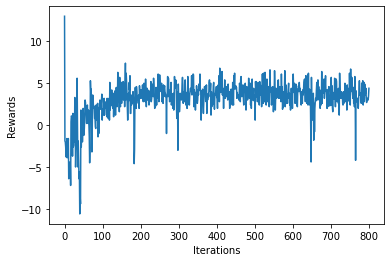

 80%|█████████████████████████████████████████████████████████████▋               | 8011/10000 [15:58<06:04,  5.45it/s]

Mean Reward = 3.0
0


 80%|█████████████████████████████████████████████████████████████▊               | 8022/10000 [16:00<04:42,  6.99it/s]

Mean Reward = 2.9
1


 80%|█████████████████████████████████████████████████████████████▊               | 8027/10000 [16:01<05:29,  5.99it/s]

Updated Weights


 80%|█████████████████████████████████████████████████████████████▊               | 8032/10000 [16:01<04:36,  7.12it/s]

Mean Reward = 4.6
1


 80%|█████████████████████████████████████████████████████████████▉               | 8042/10000 [16:03<04:45,  6.85it/s]

Mean Reward = 3.2
0


 81%|██████████████████████████████████████████████████████████████               | 8052/10000 [16:04<05:21,  6.05it/s]

Updated Weights
Mean Reward = 2.8
0


 81%|██████████████████████████████████████████████████████████████               | 8062/10000 [16:06<04:13,  7.66it/s]

Mean Reward = 3.4
0


 81%|██████████████████████████████████████████████████████████████▏              | 8072/10000 [16:07<04:11,  7.68it/s]

Mean Reward = 4.0
0


 81%|██████████████████████████████████████████████████████████████▏              | 8077/10000 [16:08<04:14,  7.57it/s]

Updated Weights


 81%|██████████████████████████████████████████████████████████████▏              | 8082/10000 [16:08<04:11,  7.61it/s]

Mean Reward = 3.8
0


 81%|██████████████████████████████████████████████████████████████▎              | 8092/10000 [16:09<04:01,  7.91it/s]

Mean Reward = 4.0
2


 81%|██████████████████████████████████████████████████████████████▍              | 8102/10000 [16:11<04:10,  7.57it/s]

Updated Weights
Mean Reward = 2.6
0


 81%|██████████████████████████████████████████████████████████████▍              | 8112/10000 [16:12<04:12,  7.48it/s]

Mean Reward = 2.4
0


 81%|██████████████████████████████████████████████████████████████▌              | 8122/10000 [16:13<04:07,  7.60it/s]

Mean Reward = 2.0
0


 81%|██████████████████████████████████████████████████████████████▌              | 8128/10000 [16:14<03:40,  8.50it/s]

Updated Weights


 81%|██████████████████████████████████████████████████████████████▌              | 8132/10000 [16:14<04:02,  7.69it/s]

Mean Reward = 4.9
1


 81%|██████████████████████████████████████████████████████████████▋              | 8142/10000 [16:16<04:13,  7.34it/s]

Mean Reward = 2.0
0


 82%|██████████████████████████████████████████████████████████████▊              | 8152/10000 [16:17<03:25,  8.99it/s]

Updated Weights
Mean Reward = 6.4
3


 82%|██████████████████████████████████████████████████████████████▊              | 8162/10000 [16:18<03:59,  7.68it/s]

Mean Reward = 3.2
0


 82%|██████████████████████████████████████████████████████████████▉              | 8172/10000 [16:19<03:50,  7.93it/s]

Mean Reward = 4.4
1


 82%|██████████████████████████████████████████████████████████████▉              | 8178/10000 [16:20<03:31,  8.60it/s]

Updated Weights


 82%|███████████████████████████████████████████████████████████████              | 8182/10000 [16:21<03:27,  8.78it/s]

Mean Reward = 4.7
2


 82%|███████████████████████████████████████████████████████████████              | 8192/10000 [16:22<03:19,  9.09it/s]

Mean Reward = 5.6
2


 82%|███████████████████████████████████████████████████████████████▏             | 8202/10000 [16:23<04:02,  7.40it/s]

Updated Weights
Mean Reward = 3.6
0


 82%|███████████████████████████████████████████████████████████████▏             | 8212/10000 [16:24<03:58,  7.50it/s]

Mean Reward = 4.0
1


 82%|███████████████████████████████████████████████████████████████▎             | 8222/10000 [16:25<03:53,  7.63it/s]

Mean Reward = 4.7
1


 82%|███████████████████████████████████████████████████████████████▎             | 8228/10000 [16:26<03:29,  8.44it/s]

Updated Weights


 82%|███████████████████████████████████████████████████████████████▍             | 8232/10000 [16:27<03:54,  7.55it/s]

Mean Reward = 4.5
1


 82%|███████████████████████████████████████████████████████████████▍             | 8242/10000 [16:28<03:51,  7.59it/s]

Mean Reward = 5.1
1


 83%|███████████████████████████████████████████████████████████████▌             | 8252/10000 [16:29<03:54,  7.45it/s]

Updated Weights
Mean Reward = 3.2
0


 83%|███████████████████████████████████████████████████████████████▌             | 8262/10000 [16:30<03:26,  8.42it/s]

Mean Reward = 4.6
2


 83%|███████████████████████████████████████████████████████████████▋             | 8272/10000 [16:32<03:50,  7.49it/s]

Mean Reward = 2.6
0


 83%|███████████████████████████████████████████████████████████████▋             | 8277/10000 [16:32<03:32,  8.10it/s]

Updated Weights


 83%|███████████████████████████████████████████████████████████████▊             | 8282/10000 [16:33<03:48,  7.53it/s]

Mean Reward = 5.2
1


 83%|███████████████████████████████████████████████████████████████▊             | 8292/10000 [16:34<03:44,  7.61it/s]

Mean Reward = 2.4
0


 83%|███████████████████████████████████████████████████████████████▉             | 8301/10000 [16:36<05:18,  5.34it/s]

Updated Weights
Mean Reward = 3.0
0


 83%|████████████████████████████████████████████████████████████████             | 8312/10000 [16:38<04:39,  6.05it/s]

Mean Reward = 4.0
0


 83%|████████████████████████████████████████████████████████████████             | 8322/10000 [16:39<03:50,  7.28it/s]

Mean Reward = 4.9
2


 83%|████████████████████████████████████████████████████████████████             | 8327/10000 [16:40<04:01,  6.94it/s]

Updated Weights


 83%|████████████████████████████████████████████████████████████████▏            | 8332/10000 [16:41<04:49,  5.77it/s]

Mean Reward = 4.2
0


 83%|████████████████████████████████████████████████████████████████▏            | 8342/10000 [16:42<04:11,  6.59it/s]

Mean Reward = 2.4
0


 84%|████████████████████████████████████████████████████████████████▎            | 8352/10000 [16:44<03:55,  7.01it/s]

Updated Weights
Mean Reward = 3.8
1


 84%|████████████████████████████████████████████████████████████████▍            | 8362/10000 [16:45<03:53,  7.00it/s]

Mean Reward = 4.3
2


 84%|████████████████████████████████████████████████████████████████▍            | 8372/10000 [16:47<05:12,  5.21it/s]

Mean Reward = 3.4
0


 84%|████████████████████████████████████████████████████████████████▌            | 8377/10000 [16:48<05:16,  5.14it/s]

Updated Weights


 84%|████████████████████████████████████████████████████████████████▌            | 8382/10000 [16:49<05:14,  5.14it/s]

Mean Reward = 2.8
0


 84%|████████████████████████████████████████████████████████████████▌            | 8392/10000 [16:50<04:12,  6.36it/s]

Mean Reward = 3.7
1


 84%|████████████████████████████████████████████████████████████████▋            | 8401/10000 [16:52<04:45,  5.61it/s]

Updated Weights
Mean Reward = 4.5
1


 84%|████████████████████████████████████████████████████████████████▊            | 8412/10000 [16:53<03:46,  7.01it/s]

Mean Reward = 6.8
4


 84%|████████████████████████████████████████████████████████████████▊            | 8422/10000 [16:55<04:32,  5.80it/s]

Mean Reward = 2.8
0


 84%|████████████████████████████████████████████████████████████████▉            | 8427/10000 [16:56<04:05,  6.42it/s]

Updated Weights


 84%|████████████████████████████████████████████████████████████████▉            | 8432/10000 [16:56<04:01,  6.48it/s]

Mean Reward = 4.4
0


 84%|█████████████████████████████████████████████████████████████████            | 8442/10000 [16:58<03:46,  6.87it/s]

Mean Reward = 4.2
1


 85%|█████████████████████████████████████████████████████████████████            | 8451/10000 [16:59<04:29,  5.76it/s]

Updated Weights
Mean Reward = 3.2
0


 85%|█████████████████████████████████████████████████████████████████▏           | 8461/10000 [17:01<04:25,  5.80it/s]

Mean Reward = 3.8
1


 85%|█████████████████████████████████████████████████████████████████▏           | 8471/10000 [17:03<05:24,  4.70it/s]

Mean Reward = 4.3
1


 85%|█████████████████████████████████████████████████████████████████▎           | 8476/10000 [17:04<05:02,  5.04it/s]

Updated Weights


 85%|█████████████████████████████████████████████████████████████████▎           | 8481/10000 [17:05<04:35,  5.52it/s]

Mean Reward = 4.6
1


 85%|█████████████████████████████████████████████████████████████████▍           | 8492/10000 [17:06<03:13,  7.81it/s]

Mean Reward = 4.3
2


 85%|█████████████████████████████████████████████████████████████████▍           | 8500/10000 [17:07<04:15,  5.88it/s]

Updated Weights
Mean Reward = 5.6
1


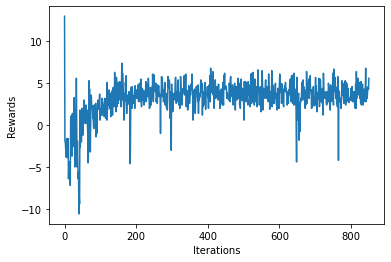

 85%|█████████████████████████████████████████████████████████████████▌           | 8512/10000 [17:10<04:00,  6.18it/s]

Mean Reward = 5.6
2


 85%|█████████████████████████████████████████████████████████████████▌           | 8521/10000 [17:11<04:07,  5.98it/s]

Mean Reward = 2.4
0


 85%|█████████████████████████████████████████████████████████████████▋           | 8528/10000 [17:12<03:20,  7.35it/s]

Updated Weights


 85%|█████████████████████████████████████████████████████████████████▋           | 8532/10000 [17:13<03:38,  6.71it/s]

Mean Reward = 3.4
1


 85%|█████████████████████████████████████████████████████████████████▊           | 8542/10000 [17:14<03:24,  7.14it/s]

Mean Reward = 6.7
3


 86%|█████████████████████████████████████████████████████████████████▊           | 8551/10000 [17:15<04:08,  5.82it/s]

Updated Weights
Mean Reward = 4.0
1


 86%|█████████████████████████████████████████████████████████████████▉           | 8562/10000 [17:17<03:58,  6.02it/s]

Mean Reward = 5.7
2


 86%|██████████████████████████████████████████████████████████████████           | 8572/10000 [17:19<03:38,  6.53it/s]

Mean Reward = 3.8
0


 86%|██████████████████████████████████████████████████████████████████           | 8577/10000 [17:19<03:30,  6.75it/s]

Updated Weights


 86%|██████████████████████████████████████████████████████████████████           | 8582/10000 [17:20<03:37,  6.53it/s]

Mean Reward = 4.6
0


 86%|██████████████████████████████████████████████████████████████████▏          | 8591/10000 [17:22<05:02,  4.67it/s]

Mean Reward = 3.6
0


 86%|██████████████████████████████████████████████████████████████████▏          | 8602/10000 [17:24<03:31,  6.62it/s]

Updated Weights
Mean Reward = 1.6
0


 86%|██████████████████████████████████████████████████████████████████▎          | 8611/10000 [17:25<03:39,  6.33it/s]

Mean Reward = 5.0
1


 86%|██████████████████████████████████████████████████████████████████▍          | 8621/10000 [17:27<04:54,  4.68it/s]

Mean Reward = 3.4
0


 86%|██████████████████████████████████████████████████████████████████▍          | 8627/10000 [17:28<03:47,  6.03it/s]

Updated Weights


 86%|██████████████████████████████████████████████████████████████████▍          | 8632/10000 [17:29<03:35,  6.35it/s]

Mean Reward = 4.1
2


 86%|██████████████████████████████████████████████████████████████████▌          | 8641/10000 [17:30<03:39,  6.19it/s]

Mean Reward = 5.4
2


 87%|██████████████████████████████████████████████████████████████████▌          | 8651/10000 [17:32<05:01,  4.48it/s]

Updated Weights
Mean Reward = 2.9
1


 87%|██████████████████████████████████████████████████████████████████▋          | 8661/10000 [17:34<03:28,  6.41it/s]

Mean Reward = 4.5
1


 87%|██████████████████████████████████████████████████████████████████▊          | 8672/10000 [17:35<03:22,  6.54it/s]

Mean Reward = 2.8
1


 87%|██████████████████████████████████████████████████████████████████▊          | 8676/10000 [17:36<03:27,  6.38it/s]

Updated Weights


 87%|██████████████████████████████████████████████████████████████████▊          | 8681/10000 [17:37<03:50,  5.73it/s]

Mean Reward = 4.8
1


 87%|██████████████████████████████████████████████████████████████████▉          | 8692/10000 [17:38<03:02,  7.15it/s]

Mean Reward = 4.4
2


 87%|███████████████████████████████████████████████████████████████████          | 8702/10000 [17:40<04:06,  5.28it/s]

Updated Weights
Mean Reward = 3.4
0


 87%|███████████████████████████████████████████████████████████████████          | 8711/10000 [17:42<04:00,  5.36it/s]

Mean Reward = 4.1
1


 87%|███████████████████████████████████████████████████████████████████▏         | 8722/10000 [17:44<03:21,  6.34it/s]

Mean Reward = 5.0
1


 87%|███████████████████████████████████████████████████████████████████▏         | 8727/10000 [17:44<03:16,  6.47it/s]

Updated Weights


 87%|███████████████████████████████████████████████████████████████████▏         | 8732/10000 [17:45<03:20,  6.33it/s]

Mean Reward = 3.0
0


 87%|███████████████████████████████████████████████████████████████████▎         | 8741/10000 [17:46<03:21,  6.26it/s]

Mean Reward = 5.0
2


 88%|███████████████████████████████████████████████████████████████████▍         | 8751/10000 [17:48<03:41,  5.64it/s]

Updated Weights
Mean Reward = 3.6
0


 88%|███████████████████████████████████████████████████████████████████▍         | 8761/10000 [17:50<03:53,  5.31it/s]

Mean Reward = 4.0
0


 88%|███████████████████████████████████████████████████████████████████▌         | 8772/10000 [17:52<03:24,  6.01it/s]

Mean Reward = 2.6
0


 88%|███████████████████████████████████████████████████████████████████▌         | 8777/10000 [17:53<03:07,  6.52it/s]

Updated Weights


 88%|███████████████████████████████████████████████████████████████████▌         | 8782/10000 [17:53<03:01,  6.73it/s]

Mean Reward = 5.4
2


 88%|███████████████████████████████████████████████████████████████████▋         | 8792/10000 [17:55<02:52,  7.00it/s]

Mean Reward = 6.2
2


 88%|███████████████████████████████████████████████████████████████████▊         | 8802/10000 [17:56<03:17,  6.06it/s]

Updated Weights
Mean Reward = 3.0
0


 88%|███████████████████████████████████████████████████████████████████▊         | 8812/10000 [17:58<03:25,  5.78it/s]

Mean Reward = 3.9
1


 88%|███████████████████████████████████████████████████████████████████▉         | 8821/10000 [17:59<03:27,  5.69it/s]

Mean Reward = 4.7
1


 88%|███████████████████████████████████████████████████████████████████▉         | 8826/10000 [18:00<03:54,  5.00it/s]

Updated Weights


 88%|███████████████████████████████████████████████████████████████████▉         | 8831/10000 [18:01<03:37,  5.37it/s]

Mean Reward = 4.8
0


 88%|████████████████████████████████████████████████████████████████████         | 8841/10000 [18:03<03:54,  4.94it/s]

Mean Reward = 4.0
1


 88%|████████████████████████████████████████████████████████████████████▏        | 8850/10000 [18:05<03:51,  4.98it/s]

Updated Weights
Mean Reward = 3.2
1


 89%|████████████████████████████████████████████████████████████████████▏        | 8862/10000 [18:07<02:25,  7.80it/s]

Mean Reward = 4.1
1


 89%|████████████████████████████████████████████████████████████████████▎        | 8872/10000 [18:08<02:37,  7.18it/s]

Mean Reward = 5.0
1


 89%|████████████████████████████████████████████████████████████████████▎        | 8877/10000 [18:09<02:40,  6.98it/s]

Updated Weights


 89%|████████████████████████████████████████████████████████████████████▍        | 8882/10000 [18:10<02:42,  6.88it/s]

Mean Reward = 1.8
0


 89%|████████████████████████████████████████████████████████████████████▍        | 8892/10000 [18:11<02:55,  6.33it/s]

Mean Reward = 1.6
0


 89%|████████████████████████████████████████████████████████████████████▌        | 8903/10000 [18:13<02:32,  7.20it/s]

Updated Weights
Mean Reward = 2.6
0


 89%|████████████████████████████████████████████████████████████████████▌        | 8912/10000 [18:14<02:37,  6.91it/s]

Mean Reward = 5.8
2


 89%|████████████████████████████████████████████████████████████████████▋        | 8921/10000 [18:16<03:29,  5.16it/s]

Mean Reward = 4.4
0


 89%|████████████████████████████████████████████████████████████████████▋        | 8927/10000 [18:17<03:11,  5.61it/s]

Updated Weights


 89%|████████████████████████████████████████████████████████████████████▊        | 8932/10000 [18:18<03:13,  5.52it/s]

Mean Reward = 4.1
1


 89%|████████████████████████████████████████████████████████████████████▊        | 8942/10000 [18:20<02:44,  6.42it/s]

Mean Reward = 3.8
0


 90%|████████████████████████████████████████████████████████████████████▉        | 8952/10000 [18:21<03:03,  5.71it/s]

Updated Weights
Mean Reward = 1.2
0


 90%|█████████████████████████████████████████████████████████████████████        | 8962/10000 [18:23<02:29,  6.95it/s]

Mean Reward = 4.0
0


 90%|█████████████████████████████████████████████████████████████████████        | 8972/10000 [18:24<02:40,  6.42it/s]

Mean Reward = 2.6
0


 90%|█████████████████████████████████████████████████████████████████████        | 8977/10000 [18:25<02:27,  6.92it/s]

Updated Weights


 90%|█████████████████████████████████████████████████████████████████████▏       | 8982/10000 [18:26<02:41,  6.29it/s]

Mean Reward = 3.8
1


 90%|█████████████████████████████████████████████████████████████████████▏       | 8991/10000 [18:27<02:58,  5.64it/s]

Mean Reward = 3.6
0


 90%|█████████████████████████████████████████████████████████████████████▎       | 9000/10000 [18:29<02:36,  6.41it/s]

Updated Weights
Mean Reward = 3.5
1


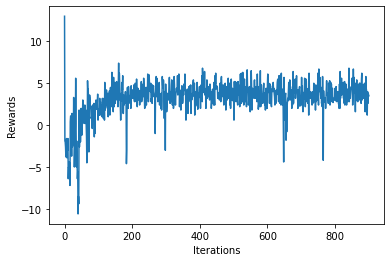

 90%|█████████████████████████████████████████████████████████████████████▍       | 9012/10000 [18:31<02:32,  6.47it/s]

Mean Reward = 3.8
1


 90%|█████████████████████████████████████████████████████████████████████▍       | 9022/10000 [18:32<02:20,  6.95it/s]

Mean Reward = 3.6
1


 90%|█████████████████████████████████████████████████████████████████████▌       | 9027/10000 [18:33<02:25,  6.67it/s]

Updated Weights


 90%|█████████████████████████████████████████████████████████████████████▌       | 9031/10000 [18:33<02:34,  6.26it/s]

Mean Reward = 3.0
0


 90%|█████████████████████████████████████████████████████████████████████▌       | 9042/10000 [18:35<02:11,  7.29it/s]

Mean Reward = 2.6
0


 91%|█████████████████████████████████████████████████████████████████████▋       | 9052/10000 [18:36<02:06,  7.52it/s]

Updated Weights
Mean Reward = 3.2
1


 91%|█████████████████████████████████████████████████████████████████████▊       | 9062/10000 [18:37<02:06,  7.40it/s]

Mean Reward = 4.5
1


 91%|█████████████████████████████████████████████████████████████████████▊       | 9073/10000 [18:39<01:43,  8.94it/s]

Mean Reward = 4.9
1


 91%|█████████████████████████████████████████████████████████████████████▉       | 9077/10000 [18:39<01:54,  8.09it/s]

Updated Weights


 91%|█████████████████████████████████████████████████████████████████████▉       | 9082/10000 [18:40<02:02,  7.51it/s]

Mean Reward = 3.8
1


 91%|██████████████████████████████████████████████████████████████████████       | 9092/10000 [18:41<01:45,  8.65it/s]

Mean Reward = 4.6
2


 91%|██████████████████████████████████████████████████████████████████████       | 9102/10000 [18:42<01:55,  7.79it/s]

Updated Weights
Mean Reward = 3.6
0


 91%|██████████████████████████████████████████████████████████████████████▏      | 9112/10000 [18:44<01:57,  7.54it/s]

Mean Reward = 3.6
1


 91%|██████████████████████████████████████████████████████████████████████▏      | 9123/10000 [18:45<01:48,  8.08it/s]

Mean Reward = 1.6
0


 91%|██████████████████████████████████████████████████████████████████████▎      | 9127/10000 [18:45<01:42,  8.54it/s]

Updated Weights


 91%|██████████████████████████████████████████████████████████████████████▎      | 9132/10000 [18:46<02:11,  6.61it/s]

Mean Reward = 4.6
2


 91%|██████████████████████████████████████████████████████████████████████▍      | 9142/10000 [18:48<01:54,  7.49it/s]

Mean Reward = 2.6
0


 92%|██████████████████████████████████████████████████████████████████████▍      | 9154/10000 [18:49<01:43,  8.18it/s]

Updated Weights
Mean Reward = 4.7
1


 92%|██████████████████████████████████████████████████████████████████████▌      | 9162/10000 [18:50<01:50,  7.58it/s]

Mean Reward = 5.1
2


 92%|██████████████████████████████████████████████████████████████████████▌      | 9172/10000 [18:51<02:02,  6.78it/s]

Mean Reward = 3.9
1


 92%|██████████████████████████████████████████████████████████████████████▋      | 9177/10000 [18:52<01:56,  7.04it/s]

Updated Weights


 92%|██████████████████████████████████████████████████████████████████████▋      | 9182/10000 [18:53<01:48,  7.56it/s]

Mean Reward = 4.1
1


 92%|██████████████████████████████████████████████████████████████████████▊      | 9192/10000 [18:54<02:00,  6.71it/s]

Mean Reward = 3.0
0


 92%|██████████████████████████████████████████████████████████████████████▊      | 9202/10000 [18:55<01:30,  8.82it/s]

Updated Weights
Mean Reward = 5.5
2


 92%|██████████████████████████████████████████████████████████████████████▉      | 9212/10000 [18:57<01:44,  7.54it/s]

Mean Reward = 4.0
0


 92%|███████████████████████████████████████████████████████████████████████      | 9222/10000 [18:58<01:43,  7.55it/s]

Mean Reward = 2.4
0


 92%|███████████████████████████████████████████████████████████████████████      | 9227/10000 [18:59<01:42,  7.52it/s]

Updated Weights


 92%|███████████████████████████████████████████████████████████████████████      | 9232/10000 [18:59<01:41,  7.59it/s]

Mean Reward = 3.2
0


 92%|███████████████████████████████████████████████████████████████████████▏     | 9243/10000 [19:01<01:26,  8.77it/s]

Mean Reward = 4.5
1


 93%|███████████████████████████████████████████████████████████████████████▏     | 9252/10000 [19:02<01:40,  7.47it/s]

Updated Weights
Mean Reward = 4.6
1


 93%|███████████████████████████████████████████████████████████████████████▎     | 9262/10000 [19:03<01:38,  7.47it/s]

Mean Reward = 2.8
0


 93%|███████████████████████████████████████████████████████████████████████▍     | 9272/10000 [19:05<01:47,  6.80it/s]

Mean Reward = 3.1
1


 93%|███████████████████████████████████████████████████████████████████████▍     | 9277/10000 [19:05<01:41,  7.12it/s]

Updated Weights


 93%|███████████████████████████████████████████████████████████████████████▍     | 9283/10000 [19:06<01:27,  8.17it/s]

Mean Reward = 3.2
0


 93%|███████████████████████████████████████████████████████████████████████▌     | 9293/10000 [19:07<01:21,  8.64it/s]

Mean Reward = 5.5
2


 93%|███████████████████████████████████████████████████████████████████████▋     | 9302/10000 [19:09<02:01,  5.77it/s]

Updated Weights
Mean Reward = 4.2
1


 93%|███████████████████████████████████████████████████████████████████████▋     | 9312/10000 [19:10<01:50,  6.20it/s]

Mean Reward = 3.2
0


 93%|███████████████████████████████████████████████████████████████████████▊     | 9322/10000 [19:12<01:47,  6.28it/s]

Mean Reward = 4.3
1


 93%|███████████████████████████████████████████████████████████████████████▊     | 9327/10000 [19:13<01:52,  5.98it/s]

Updated Weights


 93%|███████████████████████████████████████████████████████████████████████▊     | 9332/10000 [19:14<01:47,  6.22it/s]

Mean Reward = 4.1
1


 93%|███████████████████████████████████████████████████████████████████████▉     | 9342/10000 [19:15<01:51,  5.92it/s]

Mean Reward = 3.9
1


 94%|████████████████████████████████████████████████████████████████████████     | 9352/10000 [19:17<01:40,  6.44it/s]

Updated Weights
Mean Reward = 5.4
2


 94%|████████████████████████████████████████████████████████████████████████     | 9362/10000 [19:19<02:04,  5.11it/s]

Mean Reward = 3.0
0


 94%|████████████████████████████████████████████████████████████████████████▏    | 9371/10000 [19:20<01:39,  6.31it/s]

Mean Reward = 3.8
0


 94%|████████████████████████████████████████████████████████████████████████▏    | 9377/10000 [19:21<01:43,  6.04it/s]

Updated Weights


 94%|████████████████████████████████████████████████████████████████████████▏    | 9381/10000 [19:22<01:55,  5.37it/s]

Mean Reward = 2.0
0


 94%|████████████████████████████████████████████████████████████████████████▎    | 9391/10000 [19:24<02:15,  4.48it/s]

Mean Reward = 2.8
0


 94%|████████████████████████████████████████████████████████████████████████▍    | 9401/10000 [19:26<02:15,  4.43it/s]

Updated Weights
Mean Reward = 5.4
1


 94%|████████████████████████████████████████████████████████████████████████▍    | 9412/10000 [19:28<01:40,  5.82it/s]

Mean Reward = 2.8
0


 94%|████████████████████████████████████████████████████████████████████████▌    | 9422/10000 [19:30<01:30,  6.37it/s]

Mean Reward = 3.4
0


 94%|████████████████████████████████████████████████████████████████████████▌    | 9426/10000 [19:31<01:40,  5.70it/s]

Updated Weights


 94%|████████████████████████████████████████████████████████████████████████▌    | 9431/10000 [19:32<01:45,  5.38it/s]

Mean Reward = 3.4
0


 94%|████████████████████████████████████████████████████████████████████████▋    | 9442/10000 [19:33<01:19,  7.03it/s]

Mean Reward = 4.2
0


 95%|████████████████████████████████████████████████████████████████████████▊    | 9452/10000 [19:35<01:18,  7.01it/s]

Updated Weights
Mean Reward = 3.8
0


 95%|████████████████████████████████████████████████████████████████████████▊    | 9461/10000 [19:36<01:32,  5.82it/s]

Mean Reward = 5.4
2


 95%|████████████████████████████████████████████████████████████████████████▉    | 9472/10000 [19:38<01:32,  5.69it/s]

Mean Reward = 2.6
0


 95%|████████████████████████████████████████████████████████████████████████▉    | 9477/10000 [19:39<01:24,  6.17it/s]

Updated Weights


 95%|█████████████████████████████████████████████████████████████████████████    | 9482/10000 [19:40<01:19,  6.54it/s]

Mean Reward = 2.8
0


 95%|█████████████████████████████████████████████████████████████████████████    | 9491/10000 [19:41<01:51,  4.57it/s]

Mean Reward = 2.8
0


 95%|█████████████████████████████████████████████████████████████████████████▏   | 9500/10000 [19:43<01:23,  6.02it/s]

Updated Weights
Mean Reward = 1.4
0


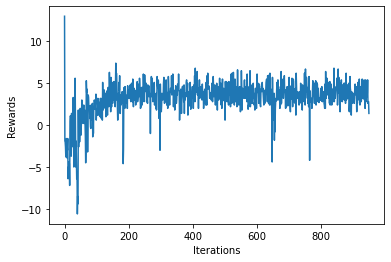

 95%|█████████████████████████████████████████████████████████████████████████▏   | 9511/10000 [19:45<01:21,  5.98it/s]

Mean Reward = 5.1
2


 95%|█████████████████████████████████████████████████████████████████████████▎   | 9522/10000 [19:47<01:23,  5.76it/s]

Mean Reward = 2.4
0


 95%|█████████████████████████████████████████████████████████████████████████▎   | 9527/10000 [19:47<01:08,  6.89it/s]

Updated Weights


 95%|█████████████████████████████████████████████████████████████████████████▍   | 9532/10000 [19:48<01:13,  6.34it/s]

Mean Reward = 4.0
1


 95%|█████████████████████████████████████████████████████████████████████████▍   | 9541/10000 [19:50<01:20,  5.68it/s]

Mean Reward = 2.4
0


 96%|█████████████████████████████████████████████████████████████████████████▌   | 9551/10000 [19:52<01:31,  4.92it/s]

Updated Weights
Mean Reward = 3.2
0


 96%|█████████████████████████████████████████████████████████████████████████▌   | 9561/10000 [19:53<01:11,  6.10it/s]

Mean Reward = 4.9
1


 96%|█████████████████████████████████████████████████████████████████████████▋   | 9572/10000 [19:55<01:06,  6.42it/s]

Mean Reward = 5.2
1


 96%|█████████████████████████████████████████████████████████████████████████▋   | 9577/10000 [19:56<01:03,  6.71it/s]

Updated Weights


 96%|█████████████████████████████████████████████████████████████████████████▊   | 9582/10000 [19:57<01:00,  6.91it/s]

Mean Reward = 2.0
0


 96%|█████████████████████████████████████████████████████████████████████████▊   | 9592/10000 [19:58<00:51,  7.85it/s]

Mean Reward = 4.4
1


 96%|█████████████████████████████████████████████████████████████████████████▉   | 9602/10000 [19:59<00:57,  6.90it/s]

Updated Weights
Mean Reward = 3.0
0


 96%|██████████████████████████████████████████████████████████████████████████   | 9612/10000 [20:01<00:54,  7.11it/s]

Mean Reward = 4.8
1


 96%|██████████████████████████████████████████████████████████████████████████   | 9622/10000 [20:02<00:53,  7.13it/s]

Mean Reward = 4.7
1


 96%|██████████████████████████████████████████████████████████████████████████▏  | 9627/10000 [20:03<00:54,  6.82it/s]

Updated Weights


 96%|██████████████████████████████████████████████████████████████████████████▏  | 9632/10000 [20:04<00:55,  6.69it/s]

Mean Reward = 3.6
0


 96%|██████████████████████████████████████████████████████████████████████████▏  | 9642/10000 [20:05<00:46,  7.74it/s]

Mean Reward = 4.8
1


 97%|██████████████████████████████████████████████████████████████████████████▎  | 9652/10000 [20:06<00:49,  7.01it/s]

Updated Weights
Mean Reward = 4.1
1


 97%|██████████████████████████████████████████████████████████████████████████▍  | 9662/10000 [20:08<00:48,  6.96it/s]

Mean Reward = 2.8
0


 97%|██████████████████████████████████████████████████████████████████████████▍  | 9672/10000 [20:09<00:46,  6.98it/s]

Mean Reward = 3.8
0


 97%|██████████████████████████████████████████████████████████████████████████▌  | 9677/10000 [20:10<00:39,  8.17it/s]

Updated Weights


 97%|██████████████████████████████████████████████████████████████████████████▌  | 9682/10000 [20:10<00:44,  7.18it/s]

Mean Reward = 4.2
1


 97%|██████████████████████████████████████████████████████████████████████████▋  | 9692/10000 [20:12<00:43,  7.15it/s]

Mean Reward = 3.8
0


 97%|██████████████████████████████████████████████████████████████████████████▋  | 9703/10000 [20:13<00:35,  8.31it/s]

Updated Weights
Mean Reward = 1.8
0


 97%|██████████████████████████████████████████████████████████████████████████▊  | 9712/10000 [20:14<00:37,  7.62it/s]

Mean Reward = 4.5
2


 97%|██████████████████████████████████████████████████████████████████████████▊  | 9722/10000 [20:16<00:42,  6.58it/s]

Mean Reward = 3.0
0


 97%|██████████████████████████████████████████████████████████████████████████▉  | 9727/10000 [20:17<00:42,  6.39it/s]

Updated Weights


 97%|██████████████████████████████████████████████████████████████████████████▉  | 9733/10000 [20:17<00:37,  7.09it/s]

Mean Reward = 4.2
0


 97%|███████████████████████████████████████████████████████████████████████████  | 9742/10000 [20:19<00:40,  6.40it/s]

Mean Reward = 6.1
1


 98%|███████████████████████████████████████████████████████████████████████████  | 9751/10000 [20:20<00:40,  6.10it/s]

Updated Weights
Mean Reward = 4.2
0


 98%|███████████████████████████████████████████████████████████████████████████▏ | 9762/10000 [20:22<00:32,  7.38it/s]

Mean Reward = 6.8
3


 98%|███████████████████████████████████████████████████████████████████████████▏ | 9772/10000 [20:23<00:33,  6.78it/s]

Mean Reward = 3.8
0


 98%|███████████████████████████████████████████████████████████████████████████▎ | 9777/10000 [20:24<00:30,  7.28it/s]

Updated Weights


 98%|███████████████████████████████████████████████████████████████████████████▎ | 9782/10000 [20:25<00:29,  7.39it/s]

Mean Reward = 3.4
0


 98%|███████████████████████████████████████████████████████████████████████████▍ | 9792/10000 [20:26<00:31,  6.68it/s]

Mean Reward = 1.6
0


 98%|███████████████████████████████████████████████████████████████████████████▍ | 9802/10000 [20:28<00:27,  7.24it/s]

Updated Weights
Mean Reward = 3.6
0


 98%|███████████████████████████████████████████████████████████████████████████▌ | 9812/10000 [20:29<00:25,  7.32it/s]

Mean Reward = 4.6
0


 98%|███████████████████████████████████████████████████████████████████████████▋ | 9822/10000 [20:30<00:25,  6.98it/s]

Mean Reward = 4.2
1


 98%|███████████████████████████████████████████████████████████████████████████▋ | 9827/10000 [20:31<00:24,  7.15it/s]

Updated Weights


 98%|███████████████████████████████████████████████████████████████████████████▋ | 9832/10000 [20:32<00:21,  7.70it/s]

Mean Reward = 3.3
1


 98%|███████████████████████████████████████████████████████████████████████████▊ | 9842/10000 [20:33<00:20,  7.54it/s]

Mean Reward = 2.8
0


 99%|███████████████████████████████████████████████████████████████████████████▊ | 9851/10000 [20:34<00:20,  7.22it/s]

Updated Weights
Mean Reward = 2.4
0


 99%|███████████████████████████████████████████████████████████████████████████▉ | 9862/10000 [20:36<00:18,  7.66it/s]

Mean Reward = 0.8
0


 99%|████████████████████████████████████████████████████████████████████████████ | 9872/10000 [20:37<00:19,  6.64it/s]

Mean Reward = 2.6
0


 99%|████████████████████████████████████████████████████████████████████████████ | 9877/10000 [20:38<00:17,  7.05it/s]

Updated Weights


 99%|████████████████████████████████████████████████████████████████████████████ | 9882/10000 [20:38<00:15,  7.86it/s]

Mean Reward = 2.4
0


 99%|████████████████████████████████████████████████████████████████████████████▏| 9892/10000 [20:40<00:13,  7.77it/s]

Mean Reward = 4.8
0


 99%|████████████████████████████████████████████████████████████████████████████▏| 9902/10000 [20:41<00:13,  7.37it/s]

Updated Weights
Mean Reward = 3.6
0


 99%|████████████████████████████████████████████████████████████████████████████▎| 9912/10000 [20:43<00:11,  7.42it/s]

Mean Reward = 3.4
0


 99%|████████████████████████████████████████████████████████████████████████████▍| 9922/10000 [20:44<00:10,  7.77it/s]

Mean Reward = 4.0
0


 99%|████████████████████████████████████████████████████████████████████████████▍| 9927/10000 [20:44<00:09,  7.93it/s]

Updated Weights


 99%|████████████████████████████████████████████████████████████████████████████▍| 9932/10000 [20:45<00:08,  7.87it/s]

Mean Reward = 5.2
0


 99%|████████████████████████████████████████████████████████████████████████████▌| 9942/10000 [20:46<00:08,  6.96it/s]

Mean Reward = 1.8
0


100%|████████████████████████████████████████████████████████████████████████████▋| 9952/10000 [20:48<00:06,  7.88it/s]

Updated Weights
Mean Reward = 3.9
1


100%|████████████████████████████████████████████████████████████████████████████▋| 9963/10000 [20:49<00:04,  8.82it/s]

Mean Reward = 4.0
1


100%|████████████████████████████████████████████████████████████████████████████▊| 9972/10000 [20:50<00:04,  6.49it/s]

Mean Reward = 5.6
2


100%|████████████████████████████████████████████████████████████████████████████▊| 9977/10000 [20:51<00:03,  7.20it/s]

Updated Weights


100%|████████████████████████████████████████████████████████████████████████████▊| 9982/10000 [20:52<00:02,  7.12it/s]

Mean Reward = 4.3
1


100%|████████████████████████████████████████████████████████████████████████████▉| 9992/10000 [20:53<00:01,  6.55it/s]

Mean Reward = 1.6
0


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [20:55<00:00,  7.97it/s]


In [5]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(10000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
#     start = np.array([0.1,0.1])
#     dest = np.array([0.1,0.3])
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()
#         mod_agent.train()
    
    if epoch>50 and epoch%25==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
#         mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    
    if epoch>50 and epoch%50==0:
        mod_agent.epsilon*=0.9
        user_agent.epsilon*=0.9
#         print(user_agent.replay_buffer.state_history[5])
#         print(user_agent.replay_buffer.action_history[5])
#         print(user_agent.replay_buffer.rewards_history[5])
#         print(user_agent.replay_buffer.next_state_history[5])

    mean_rewards.append(episode_reward)
    if epoch%10==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [6]:
user_agent.model(np.array([[0.1, 0.1, 0.1 , 0.3]]))

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.9149286 , 0.8154041 , 0.87817013, 0.9720173 ]], dtype=float32)>